# End to End Deep Learning Architectures for Automatic Modulation Recognition

This project explores the application of Convolutional Neural Networks and their applications for Automatic Modulation Recognition on the RadioML and HisarMod Datasets.

**Author:** [Timothy Do (ID:406302424)](https://timothydo.me)

## Table of Contents
<li><a href="#setup">Setup</a></li>
<li><a href="#nn">Neural Network Architectures</a></li>
<li><a href="#radio2016">RadioML 2016.10A</a></li>
<li><a href="#radio2018">RadioML 2018.01A</a></li>
<li><a href="#hisar2019">Hisar2019.1</a></li>

## References

<a href="https://arxiv.org/pdf/1602.04105.pdf">[1] T. J. O’Shea, J. Corgan, and T. C. Clancy, “Convolutional radio modulation recognition
networks,” in Engineering Applications of Neural Networks, C. Jayne and L. Iliadis, Eds.
Cham: Springer International Publishing, Aug. 2016, pp. 213-226</a> <br><br>
<a href="https://arxiv.org/pdf/1712.04578.pdf">[2] T. J. O’Shea, T. Roy, and T. C. Clancy, “Over-the-air deep learning based radio signal
classification,” IEEE J. Sel. Topics Signal Process., vol. 12, no. 1, pp. 168–179, Jan 
2018.2797</a> 

## <a name="setup">Setup</a>

In [2]:
!pip install -r requirements.txt

In [1]:
# Libraries
import h5py
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matlab.engine
import gc

# Custom Modules and Models
from models.OSheaCNN2016 import OSheaCNN2016
from models.OSheaCNN2018 import OSheaCNN2018
from models.HisarCNN2019 import HisarCNN2019
import models.train
import models.datasets

%load_ext autoreload
%autoreload 2

# Setup PyTorch Device (Assuming only Single Device)
device = 'cuda' if torch.cuda.is_available() else ('cpu')
device = torch.device(device)
gpuName = f'({torch.cuda.get_device_name(device)})' if torch.cuda.is_available() else ''
print(f'Using PyTorch Backend: {device} {gpuName}')

# Checking if the Data Path Exists for Each Dataset. Change to wherever your datasets are stored.
radioML2016 = "datasets/RML2016.10a/RML2016.10a_dict.pkl"
radioML2018 = "datasets/2018.01.OSC.0001_1024x2M.h5/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5"
hisar2019Dir = "datasets/HisarMod2019.1"
if(not(os.path.exists(radioML2016))):
    print("Please Retrieve the RadioML 2016.10A Dataset and Try Again.")
if(not(os.path.exists(radioML2018))):
    print("Please Retrieve the RadioML 2018.01A Dataset and Try Again.")
if(not(os.path.exists(hisar2019Dir))):
    print("Please Retrieve the HisarMod Dataset and Try Again.")

# Helper Function that Clears all the Dataset Variables in Memory 
def clearDatasetVars(tensors=False,verbose=False):
    datasetVars = ['X','Y','Z','X_train','X_train_val','Y_train','Y_train_val','X_val','Y_val','X_test','Y_test']
    if(tensors): # Add Tensor Variables Needed for Model Training
        tensorVars = ['train_data','valid_data','test_data','train_loader','val_loader','test_loader',
                      'model','best_model','Z_train_val','Z_train','Z_val','Z_test']
        datasetVars += tensorVars
    for datasetVar in datasetVars: # Delete in Global Variables if it Exists
        if datasetVar in globals():
            del globals()[datasetVar]
            if(verbose):
                print(f'Deleted {datasetVar}')
    gc.collect() # Disposing Garbage Memory
    if(torch.cuda.is_available()): # Free GPU Memory
        torch.cuda.empty_cache()

Using PyTorch Backend: cuda (NVIDIA GeForce RTX 3090)


## <a name="nn">Neural Network Architectures</a>

### 1. OSheaCNN2016 (RadioML 2016.10A)

In [3]:
print(OSheaCNN2016())

OSheaCNN2016(
  (conv1): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=11, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


### 2. OSheaCNN2018 (RadioML 2018.01A)

In [7]:
print(OSheaCNN2018())

OSheaCNN2018(
  (conv1): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=24, bias=True)
  (selu): SELU()
  (softmax): Softmax(dim=1)
  (max_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


### 3. HisarCNN2019 (Hisar 2019.1)

In [7]:
print(HisarCNN2019())

HisarCNN2019(
  (conv1): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=26, bias=True)
  (selu): SELU()
  (softmax): Softmax(dim=1)
  (max_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


## <a name="radio2016">RadioML 2016.01A</a>

Let's load in the RadioML 2016.01A Dataset from [Deepsig](https://deepsig.ai/datasets)!

### Data Visualization 

In [3]:
# Printing Shapes
clearDatasetVars(tensors=True)
X,Y,Z,modClasses,SNRs = models.datasets.loadRadioML2016(radioML2016)
print(X.shape)
print(Y.shape)
print(Z.shape)
N = X.shape[0]

(220000, 128, 2)
(220000, 11)
(220000, 1)


In [33]:
# Extracting Variables
labels = np.argmax(Y,axis=-1) # Decode One-Hot Encodings
classes = np.unique(labels)
print("SNRs [dB]: ",SNRs)
print("Classes: ", classes)
print("Classes Names:",modClasses)

SNRs [dB]:  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, -20, -18, -16, -14, -12, -10, -8, -6, -4, -2]
Classes:  [ 0  1  2  3  4  5  6  7  8  9 10]
Classes Names: ['CPFSK', 'QPSK', 'WBFM', 'BPSK', 'PAM4', 'QAM16', '8PSK', 'GFSK', 'AM-DSB', 'QAM64', 'AM-SSB']


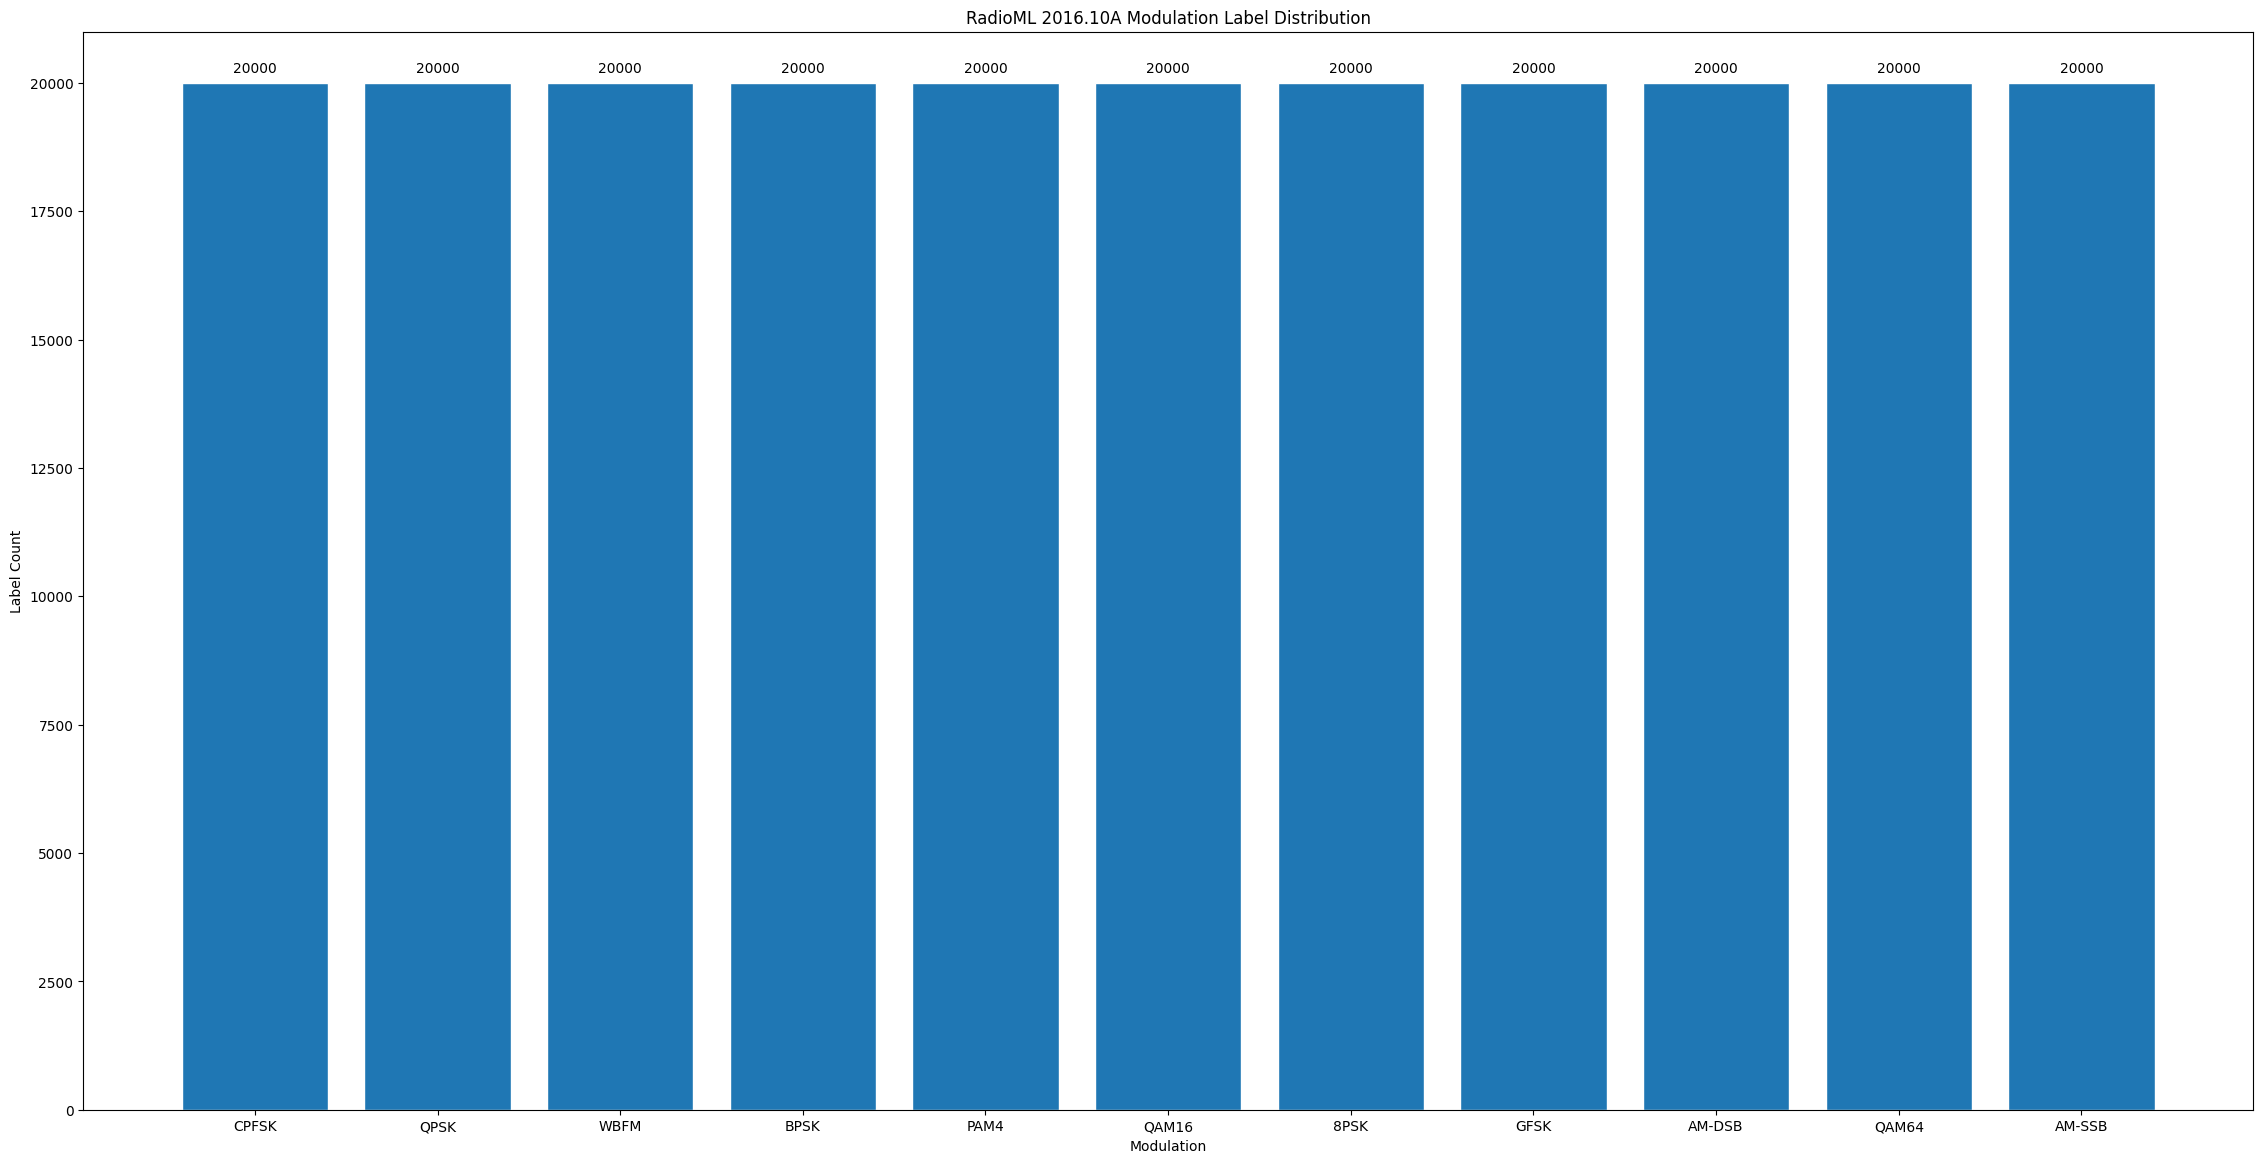

In [34]:
# Label Distribution across Modulation Classes
plt.figure(figsize=(28,14))
counts, bins = np.histogram(labels,bins=len(classes))
trainTitle = plt.title('RadioML 2016.10A Modulation Label Distribution')
trainXLabel = plt.xlabel('Modulation')
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(modClasses,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')
plt.savefig('./results/RadioML2016_ModLabelDist.png')
plt.show()

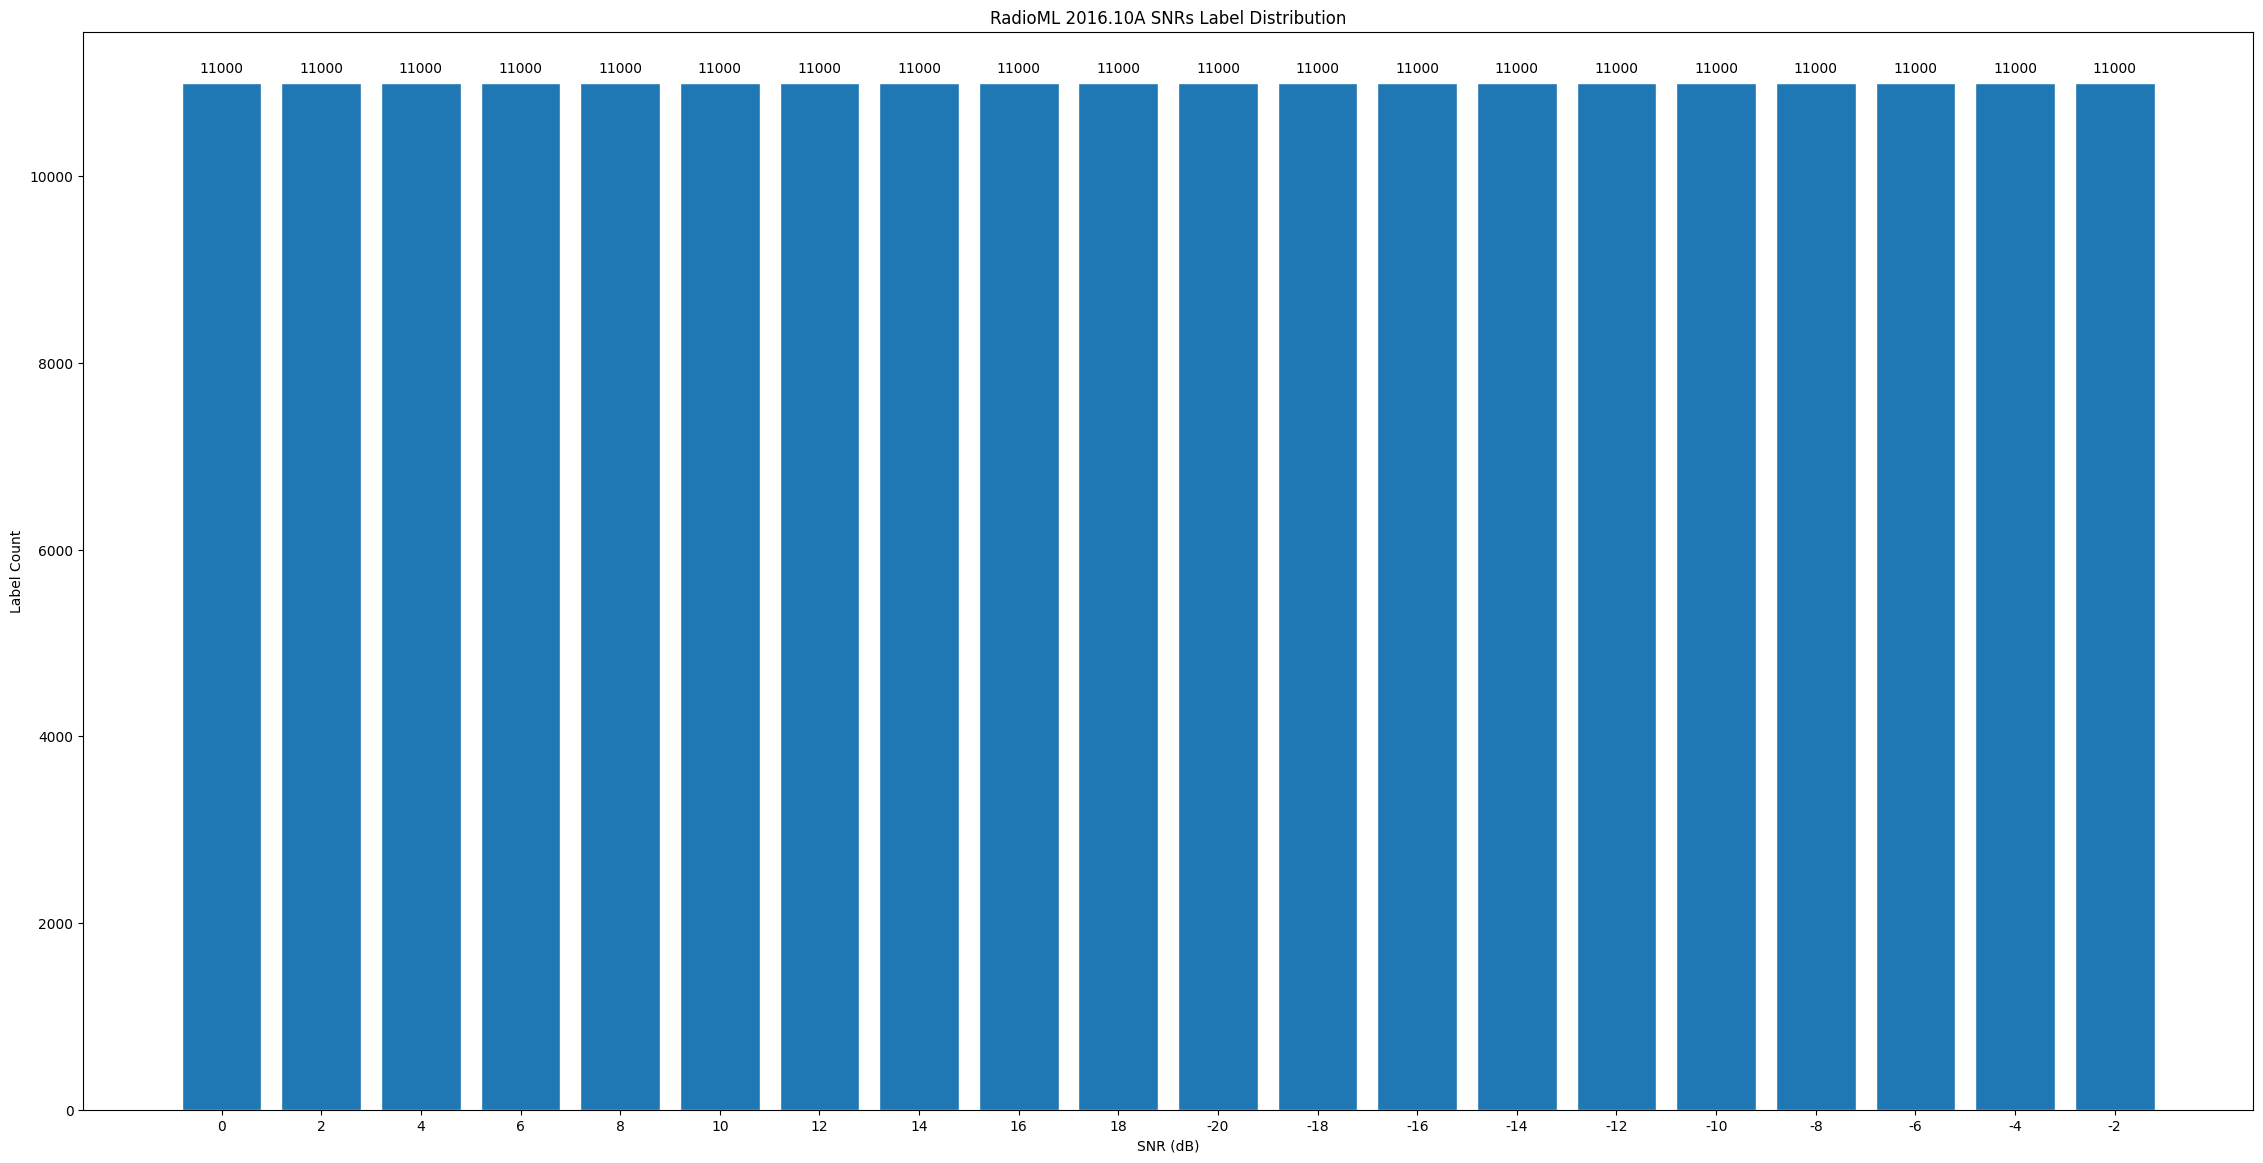

In [35]:
# Label Distribution across SNRs
SNRs_str = [str(SNR) for SNR in SNRs]
plt.figure(figsize=(28,14))
counts, bins = np.histogram(Z,bins=len(SNRs))
trainTitle = plt.title('RadioML 2016.10A SNRs Label Distribution')
trainXLabel = plt.xlabel('SNR (dB)')
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(SNRs_str,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')
plt.savefig('./results/RadioML2016_SNRLabelDist.png')
plt.show()

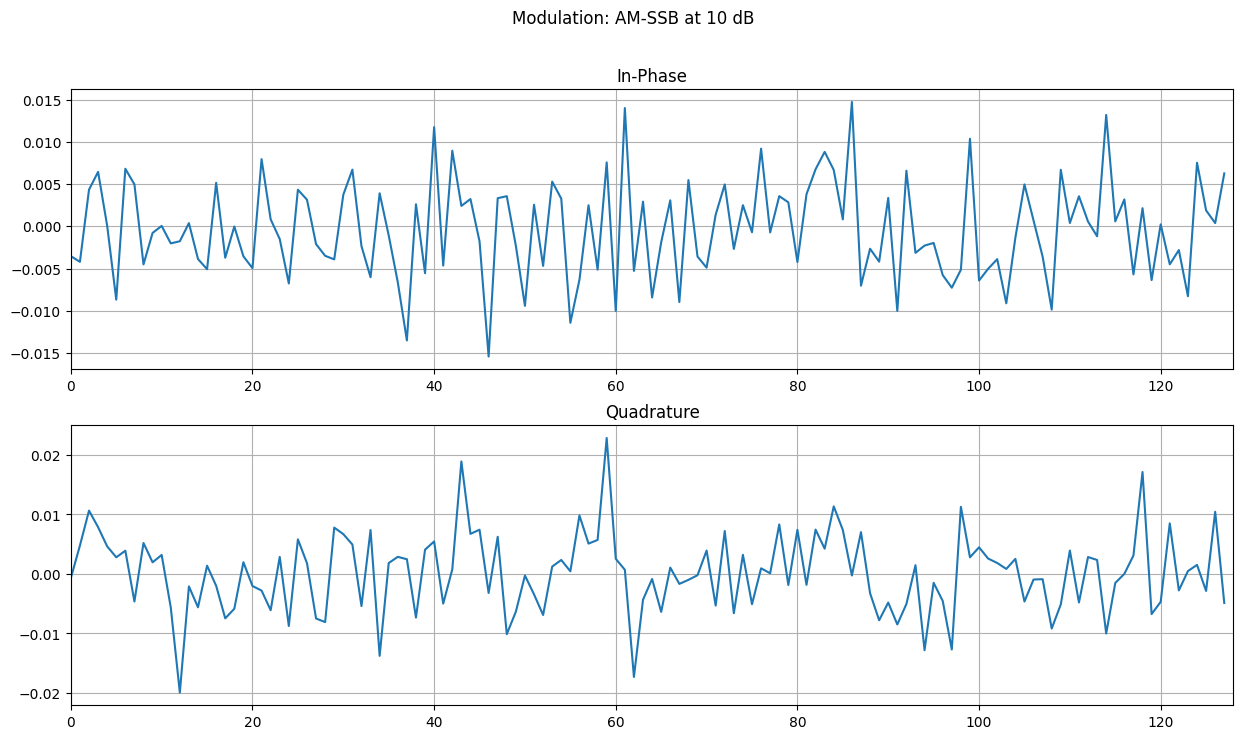

In [45]:
# IQ Temporal Sequence
index = 190000
plt.figure(figsize=(15,8))
plt.suptitle(f'Modulation: {modClasses[labels[index]]} at {Z[index][0]} dB')
plt.subplot(2,1,1)
plt.title('In-Phase')
plt.grid()
plt.plot(X[index,:,0])
plt.xlim(0,X.shape[1])
plt.subplot(2,1,2)
plt.grid()
plt.title('Quadrature')
plt.plot(X[index,:,1])
plt.xlim(0,X.shape[1])
plt.savefig(f'./results/RadioML2016_{index}_Temporal.png')
plt.show()

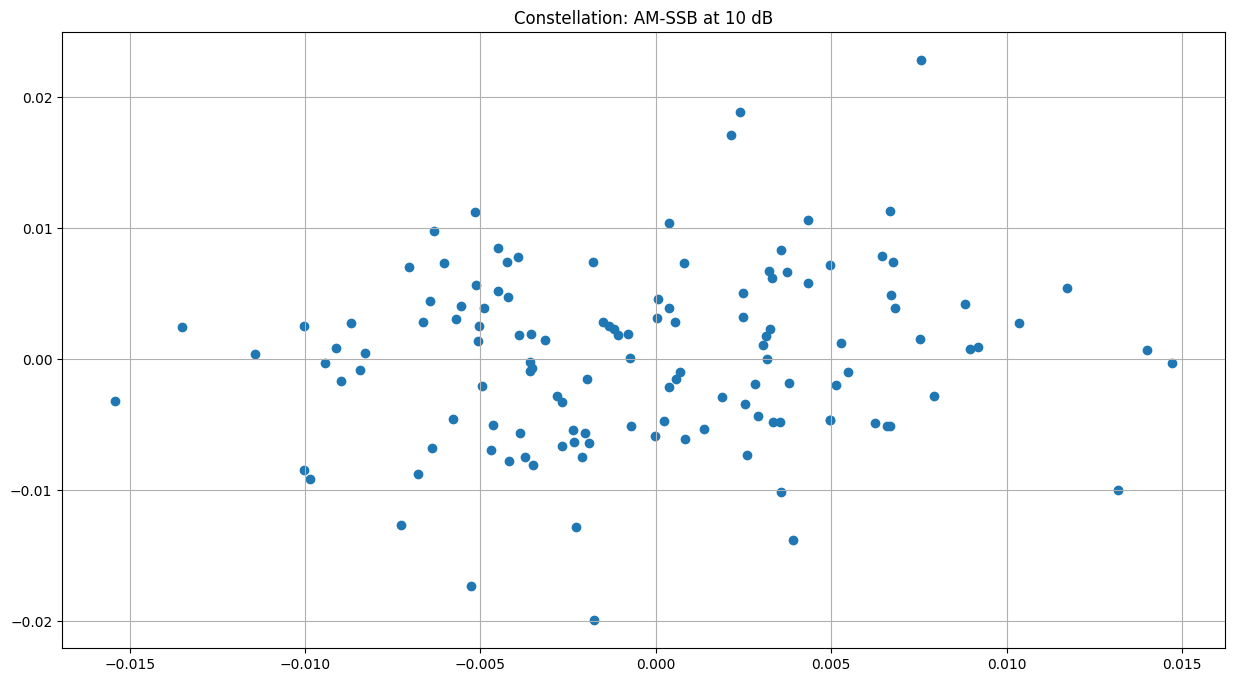

In [46]:
# Constellatino Visualization
plt.figure(figsize=(15,8))
plt.title(f'Constellation: {modClasses[labels[index]]} at {Z[index][0]} dB')
plt.scatter(X[index,:,0],X[index,:,1])
plt.grid()
plt.savefig(f'./results/RadioML2016_{index}_Constellation.png')
plt.show()

### Data Preperation

In [37]:
# Split Data into Train,Val,Test Subsets (90-5-5)%

# Warning: Memory Intensive (Can Take Upwards of 64 GB)
split = np.array([90,5,5])/100
batch_size = 1024
clearDatasetVars(tensors=True)
X,Y,Z,modClasses,SNRs = models.datasets.loadRadioML2016(radioML2016)
train_data,val_data,test_data,train_loader,val_loader,test_loader,Z_test = models.datasets.prepareDatasetRadioML(X,Y,Z,split,batch_size)

# Freeing Memory of Intermediate Values 
clearDatasetVars(tensors=False)

### Model Training and Evaluation

In [48]:
use_pretrained = False

# Define the loss function 
criterion = nn.CrossEntropyLoss()

if(use_pretrained): # Evaluate Pre-Trained Models
    modelDir = './models/OSheaCNN2016_100_best.pt'
    model = torch.load(modelDir)
    test_acc =  models.train.eval(device,model,test_loader)
    print(f'Overall Test Acc: {test_acc:.3f}')
else: # Training Model
    model = OSheaCNN2016().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-5)
    num_epochs = 250
    if(device == 'cuda'): # Free any Device Memory before Start Training
        torch.cuda.empty_cache()
    train_loss, val_loss, min_val_loss, best_model =  models.train.train_earlystop(device,model,criterion,optimizer,train_loader,val_loader,test_loader,num_epochs)
    torch.save(model,f'./models/OSheaCNN2016_{num_epochs}_last.pt')
    torch.save(best_model,f'./models/OSheaCNN2016_{num_epochs}_best.pt')
    test_last_acc = models.train.eval(device,model,test_loader)
    test_best_acc = models.train.eval(device,best_model,test_loader)
    print(f'\nOverall Test Acc (Last Epoch): {test_last_acc:.3f}')
    print(f'Overall Test Acc (Best Val): {test_best_acc:.3f}')


Starting to Train OSheaCNN2016 for 250 Epochs!


  0%|▎                                                                                 | 1/250 [00:01<07:19,  1.77s/it]

Epoch [1/250]: Train Loss: 2.398 Val Loss: 2.398 Train Acc: 0.091, Val Acc: 0.096


  1%|▋                                                                                 | 2/250 [00:03<07:00,  1.69s/it]

Epoch [2/250]: Train Loss: 2.398 Val Loss: 2.398 Train Acc: 0.090, Val Acc: 0.096


  1%|▉                                                                                 | 3/250 [00:05<06:48,  1.65s/it]

Epoch [3/250]: Train Loss: 2.398 Val Loss: 2.398 Train Acc: 0.092, Val Acc: 0.087


  2%|█▎                                                                                | 4/250 [00:06<06:41,  1.63s/it]

Epoch [4/250]: Train Loss: 2.398 Val Loss: 2.398 Train Acc: 0.091, Val Acc: 0.087


  2%|█▋                                                                                | 5/250 [00:08<06:37,  1.62s/it]

Epoch [5/250]: Train Loss: 2.398 Val Loss: 2.398 Train Acc: 0.092, Val Acc: 0.092


  2%|█▉                                                                                | 6/250 [00:09<06:40,  1.64s/it]

Epoch [6/250]: Train Loss: 2.398 Val Loss: 2.398 Train Acc: 0.091, Val Acc: 0.092


  3%|██▎                                                                               | 7/250 [00:11<06:34,  1.62s/it]

Epoch [7/250]: Train Loss: 2.396 Val Loss: 2.395 Train Acc: 0.098, Val Acc: 0.095


  3%|██▌                                                                               | 8/250 [00:13<06:30,  1.62s/it]

Epoch [8/250]: Train Loss: 2.366 Val Loss: 2.365 Train Acc: 0.115, Val Acc: 0.137


  4%|██▉                                                                               | 9/250 [00:14<06:28,  1.61s/it]

Epoch [9/250]: Train Loss: 2.347 Val Loss: 2.357 Train Acc: 0.138, Val Acc: 0.175


  4%|███▏                                                                             | 10/250 [00:16<06:26,  1.61s/it]

Epoch [10/250]: Train Loss: 2.349 Val Loss: 2.353 Train Acc: 0.151, Val Acc: 0.176


  4%|███▌                                                                             | 11/250 [00:17<06:24,  1.61s/it]

Epoch [11/250]: Train Loss: 2.356 Val Loss: 2.350 Train Acc: 0.157, Val Acc: 0.174


  5%|███▉                                                                             | 12/250 [00:19<06:26,  1.62s/it]

Epoch [12/250]: Train Loss: 2.345 Val Loss: 2.348 Train Acc: 0.160, Val Acc: 0.177


  5%|████▏                                                                            | 13/250 [00:21<06:21,  1.61s/it]

Epoch [13/250]: Train Loss: 2.328 Val Loss: 2.347 Train Acc: 0.164, Val Acc: 0.179


  6%|████▌                                                                            | 14/250 [00:22<06:18,  1.60s/it]

Epoch [14/250]: Train Loss: 2.344 Val Loss: 2.344 Train Acc: 0.169, Val Acc: 0.186


  6%|████▊                                                                            | 15/250 [00:24<06:15,  1.60s/it]

Epoch [15/250]: Train Loss: 2.344 Val Loss: 2.342 Train Acc: 0.174, Val Acc: 0.192


  6%|█████▏                                                                           | 16/250 [00:25<06:18,  1.62s/it]

Epoch [16/250]: Train Loss: 2.353 Val Loss: 2.341 Train Acc: 0.178, Val Acc: 0.193


  7%|█████▌                                                                           | 17/250 [00:27<06:16,  1.62s/it]

Epoch [17/250]: Train Loss: 2.325 Val Loss: 2.339 Train Acc: 0.183, Val Acc: 0.195


  7%|█████▊                                                                           | 18/250 [00:29<06:13,  1.61s/it]

Epoch [18/250]: Train Loss: 2.328 Val Loss: 2.336 Train Acc: 0.188, Val Acc: 0.200


  8%|██████▏                                                                          | 19/250 [00:30<06:10,  1.61s/it]

Epoch [19/250]: Train Loss: 2.331 Val Loss: 2.338 Train Acc: 0.193, Val Acc: 0.198


  8%|██████▍                                                                          | 20/250 [00:32<06:08,  1.60s/it]

Epoch [20/250]: Train Loss: 2.328 Val Loss: 2.342 Train Acc: 0.196, Val Acc: 0.184


  8%|██████▊                                                                          | 21/250 [00:33<06:06,  1.60s/it]

Epoch [21/250]: Train Loss: 2.314 Val Loss: 2.336 Train Acc: 0.201, Val Acc: 0.198


  9%|███████▏                                                                         | 22/250 [00:35<06:09,  1.62s/it]

Epoch [22/250]: Train Loss: 2.307 Val Loss: 2.332 Train Acc: 0.205, Val Acc: 0.204


  9%|███████▍                                                                         | 23/250 [00:37<06:05,  1.61s/it]

Epoch [23/250]: Train Loss: 2.320 Val Loss: 2.329 Train Acc: 0.211, Val Acc: 0.206


 10%|███████▊                                                                         | 24/250 [00:38<06:03,  1.61s/it]

Epoch [24/250]: Train Loss: 2.301 Val Loss: 2.319 Train Acc: 0.215, Val Acc: 0.227


 10%|████████                                                                         | 25/250 [00:40<06:01,  1.61s/it]

Epoch [25/250]: Train Loss: 2.304 Val Loss: 2.315 Train Acc: 0.219, Val Acc: 0.231


 10%|████████▍                                                                        | 26/250 [00:42<06:06,  1.64s/it]

Epoch [26/250]: Train Loss: 2.291 Val Loss: 2.313 Train Acc: 0.223, Val Acc: 0.234


 11%|████████▋                                                                        | 27/250 [00:43<06:03,  1.63s/it]

Epoch [27/250]: Train Loss: 2.259 Val Loss: 2.307 Train Acc: 0.226, Val Acc: 0.245


 11%|█████████                                                                        | 28/250 [00:45<05:59,  1.62s/it]

Epoch [28/250]: Train Loss: 2.289 Val Loss: 2.301 Train Acc: 0.231, Val Acc: 0.251


 12%|█████████▍                                                                       | 29/250 [00:46<05:57,  1.62s/it]

Epoch [29/250]: Train Loss: 2.310 Val Loss: 2.295 Train Acc: 0.236, Val Acc: 0.257


 12%|█████████▋                                                                       | 30/250 [00:48<05:55,  1.62s/it]

Epoch [30/250]: Train Loss: 2.296 Val Loss: 2.291 Train Acc: 0.240, Val Acc: 0.260


 12%|██████████                                                                       | 31/250 [00:50<05:52,  1.61s/it]

Epoch [31/250]: Train Loss: 2.295 Val Loss: 2.288 Train Acc: 0.243, Val Acc: 0.263


 13%|██████████▎                                                                      | 32/250 [00:51<05:54,  1.63s/it]

Epoch [32/250]: Train Loss: 2.272 Val Loss: 2.285 Train Acc: 0.247, Val Acc: 0.265


 13%|██████████▋                                                                      | 33/250 [00:53<06:04,  1.68s/it]

Epoch [33/250]: Train Loss: 2.270 Val Loss: 2.283 Train Acc: 0.248, Val Acc: 0.267


 14%|███████████                                                                      | 34/250 [00:55<06:01,  1.67s/it]

Epoch [34/250]: Train Loss: 2.287 Val Loss: 2.280 Train Acc: 0.251, Val Acc: 0.269


 14%|███████████▎                                                                     | 35/250 [00:56<05:57,  1.66s/it]

Epoch [35/250]: Train Loss: 2.270 Val Loss: 2.280 Train Acc: 0.252, Val Acc: 0.269


 14%|███████████▋                                                                     | 36/250 [00:58<05:56,  1.67s/it]

Epoch [36/250]: Train Loss: 2.249 Val Loss: 2.277 Train Acc: 0.254, Val Acc: 0.271


 15%|███████████▉                                                                     | 37/250 [01:00<05:57,  1.68s/it]

Epoch [37/250]: Train Loss: 2.293 Val Loss: 2.278 Train Acc: 0.255, Val Acc: 0.270


 15%|████████████▎                                                                    | 38/250 [01:01<05:55,  1.68s/it]

Epoch [38/250]: Train Loss: 2.250 Val Loss: 2.278 Train Acc: 0.256, Val Acc: 0.271


 16%|████████████▋                                                                    | 39/250 [01:03<05:54,  1.68s/it]

Epoch [39/250]: Train Loss: 2.276 Val Loss: 2.280 Train Acc: 0.257, Val Acc: 0.268


 16%|████████████▉                                                                    | 40/250 [01:05<05:56,  1.70s/it]

Epoch [40/250]: Train Loss: 2.225 Val Loss: 2.276 Train Acc: 0.258, Val Acc: 0.272


 16%|█████████████▎                                                                   | 41/250 [01:07<05:58,  1.72s/it]

Epoch [41/250]: Train Loss: 2.282 Val Loss: 2.277 Train Acc: 0.259, Val Acc: 0.271


 17%|█████████████▌                                                                   | 42/250 [01:08<05:53,  1.70s/it]

Epoch [42/250]: Train Loss: 2.233 Val Loss: 2.274 Train Acc: 0.261, Val Acc: 0.271


 17%|█████████████▉                                                                   | 43/250 [01:10<05:45,  1.67s/it]

Epoch [43/250]: Train Loss: 2.295 Val Loss: 2.270 Train Acc: 0.261, Val Acc: 0.277


 18%|██████████████▎                                                                  | 44/250 [01:12<05:39,  1.65s/it]

Epoch [44/250]: Train Loss: 2.275 Val Loss: 2.271 Train Acc: 0.262, Val Acc: 0.277


 18%|██████████████▌                                                                  | 45/250 [01:13<05:34,  1.63s/it]

Epoch [45/250]: Train Loss: 2.261 Val Loss: 2.272 Train Acc: 0.263, Val Acc: 0.274


 18%|██████████████▉                                                                  | 46/250 [01:15<05:34,  1.64s/it]

Epoch [46/250]: Train Loss: 2.277 Val Loss: 2.273 Train Acc: 0.264, Val Acc: 0.274


 19%|███████████████▏                                                                 | 47/250 [01:16<05:29,  1.62s/it]

Epoch [47/250]: Train Loss: 2.262 Val Loss: 2.269 Train Acc: 0.265, Val Acc: 0.277


 19%|███████████████▌                                                                 | 48/250 [01:18<05:26,  1.62s/it]

Epoch [48/250]: Train Loss: 2.274 Val Loss: 2.270 Train Acc: 0.264, Val Acc: 0.278


 20%|███████████████▉                                                                 | 49/250 [01:20<05:23,  1.61s/it]

Epoch [49/250]: Train Loss: 2.276 Val Loss: 2.265 Train Acc: 0.266, Val Acc: 0.281


 20%|████████████████▏                                                                | 50/250 [01:21<05:21,  1.61s/it]

Epoch [50/250]: Train Loss: 2.272 Val Loss: 2.269 Train Acc: 0.266, Val Acc: 0.277


 20%|████████████████▌                                                                | 51/250 [01:23<05:20,  1.61s/it]

Epoch [51/250]: Train Loss: 2.282 Val Loss: 2.267 Train Acc: 0.268, Val Acc: 0.280


 21%|████████████████▊                                                                | 52/250 [01:24<05:21,  1.62s/it]

Epoch [52/250]: Train Loss: 2.286 Val Loss: 2.265 Train Acc: 0.268, Val Acc: 0.281


 21%|█████████████████▏                                                               | 53/250 [01:26<05:18,  1.62s/it]

Epoch [53/250]: Train Loss: 2.250 Val Loss: 2.267 Train Acc: 0.268, Val Acc: 0.280


 22%|█████████████████▍                                                               | 54/250 [01:28<05:15,  1.61s/it]

Epoch [54/250]: Train Loss: 2.273 Val Loss: 2.265 Train Acc: 0.269, Val Acc: 0.281


 22%|█████████████████▊                                                               | 55/250 [01:29<05:14,  1.61s/it]

Epoch [55/250]: Train Loss: 2.245 Val Loss: 2.263 Train Acc: 0.269, Val Acc: 0.282


 22%|██████████████████▏                                                              | 56/250 [01:31<05:16,  1.63s/it]

Epoch [56/250]: Train Loss: 2.278 Val Loss: 2.266 Train Acc: 0.270, Val Acc: 0.281


 23%|██████████████████▍                                                              | 57/250 [01:33<05:13,  1.62s/it]

Epoch [57/250]: Train Loss: 2.259 Val Loss: 2.261 Train Acc: 0.271, Val Acc: 0.284


 23%|██████████████████▊                                                              | 58/250 [01:34<05:09,  1.61s/it]

Epoch [58/250]: Train Loss: 2.250 Val Loss: 2.260 Train Acc: 0.272, Val Acc: 0.286


 24%|███████████████████                                                              | 59/250 [01:36<05:08,  1.61s/it]

Epoch [59/250]: Train Loss: 2.232 Val Loss: 2.261 Train Acc: 0.274, Val Acc: 0.289


 24%|███████████████████▍                                                             | 60/250 [01:37<05:04,  1.60s/it]

Epoch [60/250]: Train Loss: 2.275 Val Loss: 2.262 Train Acc: 0.275, Val Acc: 0.290


 24%|███████████████████▊                                                             | 61/250 [01:39<05:02,  1.60s/it]

Epoch [61/250]: Train Loss: 2.255 Val Loss: 2.260 Train Acc: 0.275, Val Acc: 0.294


 25%|████████████████████                                                             | 62/250 [01:41<05:04,  1.62s/it]

Epoch [62/250]: Train Loss: 2.252 Val Loss: 2.261 Train Acc: 0.276, Val Acc: 0.295


 25%|████████████████████▍                                                            | 63/250 [01:42<05:02,  1.62s/it]

Epoch [63/250]: Train Loss: 2.233 Val Loss: 2.261 Train Acc: 0.278, Val Acc: 0.294


 26%|████████████████████▋                                                            | 64/250 [01:44<04:59,  1.61s/it]

Epoch [64/250]: Train Loss: 2.227 Val Loss: 2.255 Train Acc: 0.279, Val Acc: 0.299


 26%|█████████████████████                                                            | 65/250 [01:45<04:56,  1.60s/it]

Epoch [65/250]: Train Loss: 2.255 Val Loss: 2.258 Train Acc: 0.280, Val Acc: 0.295


 26%|█████████████████████▍                                                           | 66/250 [01:47<04:59,  1.63s/it]

Epoch [66/250]: Train Loss: 2.242 Val Loss: 2.254 Train Acc: 0.281, Val Acc: 0.301


 27%|█████████████████████▋                                                           | 67/250 [01:49<04:56,  1.62s/it]

Epoch [67/250]: Train Loss: 2.266 Val Loss: 2.252 Train Acc: 0.282, Val Acc: 0.302


 27%|██████████████████████                                                           | 68/250 [01:50<04:52,  1.61s/it]

Epoch [68/250]: Train Loss: 2.251 Val Loss: 2.253 Train Acc: 0.282, Val Acc: 0.300


 28%|██████████████████████▎                                                          | 69/250 [01:52<04:50,  1.61s/it]

Epoch [69/250]: Train Loss: 2.248 Val Loss: 2.248 Train Acc: 0.284, Val Acc: 0.303


 28%|██████████████████████▋                                                          | 70/250 [01:53<04:48,  1.60s/it]

Epoch [70/250]: Train Loss: 2.213 Val Loss: 2.248 Train Acc: 0.285, Val Acc: 0.303


 28%|███████████████████████                                                          | 71/250 [01:55<04:46,  1.60s/it]

Epoch [71/250]: Train Loss: 2.264 Val Loss: 2.247 Train Acc: 0.286, Val Acc: 0.305


 29%|███████████████████████▎                                                         | 72/250 [01:57<04:46,  1.61s/it]

Epoch [72/250]: Train Loss: 2.255 Val Loss: 2.250 Train Acc: 0.287, Val Acc: 0.301


 29%|███████████████████████▋                                                         | 73/250 [01:58<04:44,  1.61s/it]

Epoch [73/250]: Train Loss: 2.256 Val Loss: 2.248 Train Acc: 0.288, Val Acc: 0.301


 30%|███████████████████████▉                                                         | 74/250 [02:00<04:43,  1.61s/it]

Epoch [74/250]: Train Loss: 2.248 Val Loss: 2.244 Train Acc: 0.289, Val Acc: 0.304


 30%|████████████████████████▎                                                        | 75/250 [02:02<04:47,  1.64s/it]

Epoch [75/250]: Train Loss: 2.230 Val Loss: 2.244 Train Acc: 0.289, Val Acc: 0.305


 30%|████████████████████████▌                                                        | 76/250 [02:03<04:46,  1.65s/it]

Epoch [76/250]: Train Loss: 2.244 Val Loss: 2.242 Train Acc: 0.290, Val Acc: 0.307


 31%|████████████████████████▉                                                        | 77/250 [02:05<04:48,  1.67s/it]

Epoch [77/250]: Train Loss: 2.242 Val Loss: 2.242 Train Acc: 0.293, Val Acc: 0.306


 31%|█████████████████████████▎                                                       | 78/250 [02:07<04:48,  1.68s/it]

Epoch [78/250]: Train Loss: 2.225 Val Loss: 2.238 Train Acc: 0.293, Val Acc: 0.308


 32%|█████████████████████████▌                                                       | 79/250 [02:08<04:42,  1.65s/it]

Epoch [79/250]: Train Loss: 2.264 Val Loss: 2.238 Train Acc: 0.293, Val Acc: 0.311


 32%|█████████████████████████▉                                                       | 80/250 [02:10<04:42,  1.66s/it]

Epoch [80/250]: Train Loss: 2.247 Val Loss: 2.236 Train Acc: 0.295, Val Acc: 0.311


 32%|██████████████████████████▏                                                      | 81/250 [02:12<04:43,  1.68s/it]

Epoch [81/250]: Train Loss: 2.225 Val Loss: 2.236 Train Acc: 0.297, Val Acc: 0.311


 33%|██████████████████████████▌                                                      | 82/250 [02:13<04:47,  1.71s/it]

Epoch [82/250]: Train Loss: 2.243 Val Loss: 2.234 Train Acc: 0.297, Val Acc: 0.312


 33%|██████████████████████████▉                                                      | 83/250 [02:15<04:51,  1.75s/it]

Epoch [83/250]: Train Loss: 2.247 Val Loss: 2.234 Train Acc: 0.297, Val Acc: 0.313


 34%|███████████████████████████▏                                                     | 84/250 [02:17<04:52,  1.76s/it]

Epoch [84/250]: Train Loss: 2.246 Val Loss: 2.233 Train Acc: 0.298, Val Acc: 0.313


 34%|███████████████████████████▌                                                     | 85/250 [02:19<04:51,  1.77s/it]

Epoch [85/250]: Train Loss: 2.252 Val Loss: 2.232 Train Acc: 0.299, Val Acc: 0.316


 34%|███████████████████████████▊                                                     | 86/250 [02:21<04:53,  1.79s/it]

Epoch [86/250]: Train Loss: 2.210 Val Loss: 2.230 Train Acc: 0.300, Val Acc: 0.315


 35%|████████████████████████████▏                                                    | 87/250 [02:22<04:47,  1.77s/it]

Epoch [87/250]: Train Loss: 2.245 Val Loss: 2.231 Train Acc: 0.301, Val Acc: 0.316


 35%|████████████████████████████▌                                                    | 88/250 [02:24<04:50,  1.79s/it]

Epoch [88/250]: Train Loss: 2.215 Val Loss: 2.230 Train Acc: 0.302, Val Acc: 0.317


 36%|████████████████████████████▊                                                    | 89/250 [02:26<04:49,  1.80s/it]

Epoch [89/250]: Train Loss: 2.245 Val Loss: 2.227 Train Acc: 0.301, Val Acc: 0.318


 36%|█████████████████████████████▏                                                   | 90/250 [02:28<04:42,  1.77s/it]

Epoch [90/250]: Train Loss: 2.193 Val Loss: 2.225 Train Acc: 0.303, Val Acc: 0.321


 36%|█████████████████████████████▍                                                   | 91/250 [02:29<04:36,  1.74s/it]

Epoch [91/250]: Train Loss: 2.240 Val Loss: 2.225 Train Acc: 0.304, Val Acc: 0.321


 37%|█████████████████████████████▊                                                   | 92/250 [02:31<04:36,  1.75s/it]

Epoch [92/250]: Train Loss: 2.234 Val Loss: 2.222 Train Acc: 0.305, Val Acc: 0.322


 37%|██████████████████████████████▏                                                  | 93/250 [02:33<04:29,  1.72s/it]

Epoch [93/250]: Train Loss: 2.234 Val Loss: 2.226 Train Acc: 0.305, Val Acc: 0.321


 38%|██████████████████████████████▍                                                  | 94/250 [02:35<04:24,  1.70s/it]

Epoch [94/250]: Train Loss: 2.230 Val Loss: 2.223 Train Acc: 0.307, Val Acc: 0.322


 38%|██████████████████████████████▊                                                  | 95/250 [02:36<04:22,  1.69s/it]

Epoch [95/250]: Train Loss: 2.231 Val Loss: 2.220 Train Acc: 0.307, Val Acc: 0.326


 38%|███████████████████████████████                                                  | 96/250 [02:38<04:23,  1.71s/it]

Epoch [96/250]: Train Loss: 2.207 Val Loss: 2.220 Train Acc: 0.307, Val Acc: 0.326


 39%|███████████████████████████████▍                                                 | 97/250 [02:40<04:21,  1.71s/it]

Epoch [97/250]: Train Loss: 2.195 Val Loss: 2.222 Train Acc: 0.308, Val Acc: 0.324


 39%|███████████████████████████████▊                                                 | 98/250 [02:41<04:19,  1.71s/it]

Epoch [98/250]: Train Loss: 2.223 Val Loss: 2.224 Train Acc: 0.308, Val Acc: 0.324


 40%|████████████████████████████████                                                 | 99/250 [02:43<04:16,  1.70s/it]

Epoch [99/250]: Train Loss: 2.222 Val Loss: 2.220 Train Acc: 0.310, Val Acc: 0.329


 40%|████████████████████████████████                                                | 100/250 [02:45<04:17,  1.72s/it]

Epoch [100/250]: Train Loss: 2.242 Val Loss: 2.218 Train Acc: 0.311, Val Acc: 0.331


 40%|████████████████████████████████▎                                               | 101/250 [02:47<04:15,  1.72s/it]

Epoch [101/250]: Train Loss: 2.204 Val Loss: 2.216 Train Acc: 0.312, Val Acc: 0.335


 41%|████████████████████████████████▋                                               | 102/250 [02:48<04:14,  1.72s/it]

Epoch [102/250]: Train Loss: 2.244 Val Loss: 2.215 Train Acc: 0.313, Val Acc: 0.335


 41%|████████████████████████████████▉                                               | 103/250 [02:50<04:09,  1.70s/it]

Epoch [103/250]: Train Loss: 2.233 Val Loss: 2.217 Train Acc: 0.313, Val Acc: 0.334


 42%|█████████████████████████████████▎                                              | 104/250 [02:52<04:05,  1.68s/it]

Epoch [104/250]: Train Loss: 2.212 Val Loss: 2.214 Train Acc: 0.314, Val Acc: 0.336


 42%|█████████████████████████████████▌                                              | 105/250 [02:53<04:03,  1.68s/it]

Epoch [105/250]: Train Loss: 2.203 Val Loss: 2.212 Train Acc: 0.316, Val Acc: 0.339


 42%|█████████████████████████████████▉                                              | 106/250 [02:55<04:04,  1.70s/it]

Epoch [106/250]: Train Loss: 2.246 Val Loss: 2.211 Train Acc: 0.318, Val Acc: 0.338


 43%|██████████████████████████████████▏                                             | 107/250 [02:57<04:05,  1.72s/it]

Epoch [107/250]: Train Loss: 2.204 Val Loss: 2.208 Train Acc: 0.317, Val Acc: 0.342


 43%|██████████████████████████████████▌                                             | 108/250 [02:58<04:02,  1.71s/it]

Epoch [108/250]: Train Loss: 2.222 Val Loss: 2.207 Train Acc: 0.317, Val Acc: 0.344


 44%|██████████████████████████████████▉                                             | 109/250 [03:00<03:56,  1.68s/it]

Epoch [109/250]: Train Loss: 2.223 Val Loss: 2.208 Train Acc: 0.318, Val Acc: 0.343


 44%|███████████████████████████████████▏                                            | 110/250 [03:02<03:56,  1.69s/it]

Epoch [110/250]: Train Loss: 2.217 Val Loss: 2.206 Train Acc: 0.319, Val Acc: 0.347


 44%|███████████████████████████████████▌                                            | 111/250 [03:03<03:54,  1.69s/it]

Epoch [111/250]: Train Loss: 2.183 Val Loss: 2.205 Train Acc: 0.320, Val Acc: 0.348


 45%|███████████████████████████████████▊                                            | 112/250 [03:05<03:53,  1.69s/it]

Epoch [112/250]: Train Loss: 2.209 Val Loss: 2.205 Train Acc: 0.320, Val Acc: 0.347


 45%|████████████████████████████████████▏                                           | 113/250 [03:07<03:52,  1.69s/it]

Epoch [113/250]: Train Loss: 2.208 Val Loss: 2.204 Train Acc: 0.321, Val Acc: 0.348


 46%|████████████████████████████████████▍                                           | 114/250 [03:09<03:52,  1.71s/it]

Epoch [114/250]: Train Loss: 2.228 Val Loss: 2.204 Train Acc: 0.321, Val Acc: 0.350


 46%|████████████████████████████████████▊                                           | 115/250 [03:10<03:49,  1.70s/it]

Epoch [115/250]: Train Loss: 2.211 Val Loss: 2.201 Train Acc: 0.322, Val Acc: 0.350


 46%|█████████████████████████████████████                                           | 116/250 [03:12<03:50,  1.72s/it]

Epoch [116/250]: Train Loss: 2.205 Val Loss: 2.201 Train Acc: 0.323, Val Acc: 0.352


 47%|█████████████████████████████████████▍                                          | 117/250 [03:14<03:48,  1.71s/it]

Epoch [117/250]: Train Loss: 2.196 Val Loss: 2.201 Train Acc: 0.323, Val Acc: 0.350


 47%|█████████████████████████████████████▊                                          | 118/250 [03:15<03:48,  1.73s/it]

Epoch [118/250]: Train Loss: 2.224 Val Loss: 2.200 Train Acc: 0.323, Val Acc: 0.353


 48%|██████████████████████████████████████                                          | 119/250 [03:17<03:44,  1.72s/it]

Epoch [119/250]: Train Loss: 2.218 Val Loss: 2.201 Train Acc: 0.324, Val Acc: 0.352


 48%|██████████████████████████████████████▍                                         | 120/250 [03:19<03:41,  1.70s/it]

Epoch [120/250]: Train Loss: 2.216 Val Loss: 2.199 Train Acc: 0.325, Val Acc: 0.354


 48%|██████████████████████████████████████▋                                         | 121/250 [03:20<03:35,  1.67s/it]

Epoch [121/250]: Train Loss: 2.228 Val Loss: 2.199 Train Acc: 0.326, Val Acc: 0.355


 49%|███████████████████████████████████████                                         | 122/250 [03:22<03:32,  1.66s/it]

Epoch [122/250]: Train Loss: 2.201 Val Loss: 2.199 Train Acc: 0.327, Val Acc: 0.356


 49%|███████████████████████████████████████▎                                        | 123/250 [03:24<03:28,  1.65s/it]

Epoch [123/250]: Train Loss: 2.247 Val Loss: 2.197 Train Acc: 0.327, Val Acc: 0.357


 50%|███████████████████████████████████████▋                                        | 124/250 [03:25<03:25,  1.63s/it]

Epoch [124/250]: Train Loss: 2.229 Val Loss: 2.197 Train Acc: 0.328, Val Acc: 0.359


 50%|████████████████████████████████████████                                        | 125/250 [03:27<03:22,  1.62s/it]

Epoch [125/250]: Train Loss: 2.243 Val Loss: 2.196 Train Acc: 0.329, Val Acc: 0.358


 50%|████████████████████████████████████████▎                                       | 126/250 [03:29<03:22,  1.64s/it]

Epoch [126/250]: Train Loss: 2.222 Val Loss: 2.194 Train Acc: 0.330, Val Acc: 0.360


 51%|████████████████████████████████████████▋                                       | 127/250 [03:30<03:19,  1.62s/it]

Epoch [127/250]: Train Loss: 2.222 Val Loss: 2.195 Train Acc: 0.331, Val Acc: 0.360


 51%|████████████████████████████████████████▉                                       | 128/250 [03:32<03:17,  1.62s/it]

Epoch [128/250]: Train Loss: 2.214 Val Loss: 2.193 Train Acc: 0.330, Val Acc: 0.362


 52%|█████████████████████████████████████████▎                                      | 129/250 [03:33<03:14,  1.61s/it]

Epoch [129/250]: Train Loss: 2.225 Val Loss: 2.191 Train Acc: 0.332, Val Acc: 0.363


 52%|█████████████████████████████████████████▌                                      | 130/250 [03:35<03:13,  1.62s/it]

Epoch [130/250]: Train Loss: 2.187 Val Loss: 2.193 Train Acc: 0.333, Val Acc: 0.361


 52%|█████████████████████████████████████████▉                                      | 131/250 [03:37<03:11,  1.61s/it]

Epoch [131/250]: Train Loss: 2.198 Val Loss: 2.190 Train Acc: 0.333, Val Acc: 0.364


 53%|██████████████████████████████████████████▏                                     | 132/250 [03:38<03:12,  1.63s/it]

Epoch [132/250]: Train Loss: 2.197 Val Loss: 2.191 Train Acc: 0.334, Val Acc: 0.365


 53%|██████████████████████████████████████████▌                                     | 133/250 [03:40<03:09,  1.62s/it]

Epoch [133/250]: Train Loss: 2.202 Val Loss: 2.186 Train Acc: 0.335, Val Acc: 0.366


 54%|██████████████████████████████████████████▉                                     | 134/250 [03:41<03:07,  1.61s/it]

Epoch [134/250]: Train Loss: 2.201 Val Loss: 2.185 Train Acc: 0.337, Val Acc: 0.368


 54%|███████████████████████████████████████████▏                                    | 135/250 [03:43<03:04,  1.61s/it]

Epoch [135/250]: Train Loss: 2.172 Val Loss: 2.187 Train Acc: 0.336, Val Acc: 0.366


 54%|███████████████████████████████████████████▌                                    | 136/250 [03:45<03:04,  1.62s/it]

Epoch [136/250]: Train Loss: 2.195 Val Loss: 2.185 Train Acc: 0.338, Val Acc: 0.368


 55%|███████████████████████████████████████████▊                                    | 137/250 [03:46<03:02,  1.62s/it]

Epoch [137/250]: Train Loss: 2.196 Val Loss: 2.182 Train Acc: 0.338, Val Acc: 0.370


 55%|████████████████████████████████████████████▏                                   | 138/250 [03:48<03:01,  1.62s/it]

Epoch [138/250]: Train Loss: 2.180 Val Loss: 2.182 Train Acc: 0.339, Val Acc: 0.370


 56%|████████████████████████████████████████████▍                                   | 139/250 [03:50<03:00,  1.62s/it]

Epoch [139/250]: Train Loss: 2.205 Val Loss: 2.183 Train Acc: 0.340, Val Acc: 0.370


 56%|████████████████████████████████████████████▊                                   | 140/250 [03:51<02:59,  1.63s/it]

Epoch [140/250]: Train Loss: 2.195 Val Loss: 2.180 Train Acc: 0.341, Val Acc: 0.371


 56%|█████████████████████████████████████████████                                   | 141/250 [03:53<02:57,  1.63s/it]

Epoch [141/250]: Train Loss: 2.179 Val Loss: 2.180 Train Acc: 0.341, Val Acc: 0.372


 57%|█████████████████████████████████████████████▍                                  | 142/250 [03:54<02:56,  1.63s/it]

Epoch [142/250]: Train Loss: 2.202 Val Loss: 2.179 Train Acc: 0.342, Val Acc: 0.371


 57%|█████████████████████████████████████████████▊                                  | 143/250 [03:56<02:53,  1.63s/it]

Epoch [143/250]: Train Loss: 2.218 Val Loss: 2.179 Train Acc: 0.342, Val Acc: 0.372


 58%|██████████████████████████████████████████████                                  | 144/250 [03:58<02:52,  1.62s/it]

Epoch [144/250]: Train Loss: 2.152 Val Loss: 2.178 Train Acc: 0.344, Val Acc: 0.373


 58%|██████████████████████████████████████████████▍                                 | 145/250 [03:59<02:49,  1.62s/it]

Epoch [145/250]: Train Loss: 2.188 Val Loss: 2.180 Train Acc: 0.345, Val Acc: 0.372


 58%|██████████████████████████████████████████████▋                                 | 146/250 [04:01<02:49,  1.63s/it]

Epoch [146/250]: Train Loss: 2.230 Val Loss: 2.176 Train Acc: 0.344, Val Acc: 0.375


 59%|███████████████████████████████████████████████                                 | 147/250 [04:03<02:47,  1.62s/it]

Epoch [147/250]: Train Loss: 2.195 Val Loss: 2.174 Train Acc: 0.346, Val Acc: 0.377


 59%|███████████████████████████████████████████████▎                                | 148/250 [04:04<02:44,  1.61s/it]

Epoch [148/250]: Train Loss: 2.175 Val Loss: 2.174 Train Acc: 0.347, Val Acc: 0.380


 60%|███████████████████████████████████████████████▋                                | 149/250 [04:06<02:42,  1.60s/it]

Epoch [149/250]: Train Loss: 2.175 Val Loss: 2.173 Train Acc: 0.348, Val Acc: 0.378


 60%|████████████████████████████████████████████████                                | 150/250 [04:07<02:39,  1.60s/it]

Epoch [150/250]: Train Loss: 2.204 Val Loss: 2.171 Train Acc: 0.347, Val Acc: 0.379


 60%|████████████████████████████████████████████████▎                               | 151/250 [04:09<02:38,  1.60s/it]

Epoch [151/250]: Train Loss: 2.194 Val Loss: 2.177 Train Acc: 0.348, Val Acc: 0.375


 61%|████████████████████████████████████████████████▋                               | 152/250 [04:11<02:37,  1.61s/it]

Epoch [152/250]: Train Loss: 2.197 Val Loss: 2.172 Train Acc: 0.349, Val Acc: 0.380


 61%|████████████████████████████████████████████████▉                               | 153/250 [04:12<02:35,  1.61s/it]

Epoch [153/250]: Train Loss: 2.200 Val Loss: 2.171 Train Acc: 0.350, Val Acc: 0.380


 62%|█████████████████████████████████████████████████▎                              | 154/250 [04:14<02:34,  1.61s/it]

Epoch [154/250]: Train Loss: 2.226 Val Loss: 2.171 Train Acc: 0.350, Val Acc: 0.380


 62%|█████████████████████████████████████████████████▌                              | 155/250 [04:15<02:32,  1.60s/it]

Epoch [155/250]: Train Loss: 2.205 Val Loss: 2.172 Train Acc: 0.350, Val Acc: 0.380


 62%|█████████████████████████████████████████████████▉                              | 156/250 [04:17<02:32,  1.62s/it]

Epoch [156/250]: Train Loss: 2.175 Val Loss: 2.174 Train Acc: 0.350, Val Acc: 0.378


 63%|██████████████████████████████████████████████████▏                             | 157/250 [04:19<02:29,  1.61s/it]

Epoch [157/250]: Train Loss: 2.171 Val Loss: 2.173 Train Acc: 0.351, Val Acc: 0.379


 63%|██████████████████████████████████████████████████▌                             | 158/250 [04:20<02:27,  1.61s/it]

Epoch [158/250]: Train Loss: 2.182 Val Loss: 2.171 Train Acc: 0.351, Val Acc: 0.380


 64%|██████████████████████████████████████████████████▉                             | 159/250 [04:22<02:25,  1.60s/it]

Epoch [159/250]: Train Loss: 2.183 Val Loss: 2.171 Train Acc: 0.352, Val Acc: 0.380


 64%|███████████████████████████████████████████████████▏                            | 160/250 [04:23<02:24,  1.60s/it]

Epoch [160/250]: Train Loss: 2.167 Val Loss: 2.175 Train Acc: 0.352, Val Acc: 0.379


 64%|███████████████████████████████████████████████████▌                            | 161/250 [04:25<02:22,  1.60s/it]

Epoch [161/250]: Train Loss: 2.190 Val Loss: 2.172 Train Acc: 0.353, Val Acc: 0.382


 65%|███████████████████████████████████████████████████▊                            | 162/250 [04:27<02:24,  1.64s/it]

Epoch [162/250]: Train Loss: 2.181 Val Loss: 2.171 Train Acc: 0.353, Val Acc: 0.379


 65%|████████████████████████████████████████████████████▏                           | 163/250 [04:29<02:28,  1.71s/it]

Epoch [163/250]: Train Loss: 2.207 Val Loss: 2.172 Train Acc: 0.352, Val Acc: 0.380


 66%|████████████████████████████████████████████████████▍                           | 164/250 [04:30<02:30,  1.75s/it]

Epoch [164/250]: Train Loss: 2.166 Val Loss: 2.172 Train Acc: 0.355, Val Acc: 0.382


 66%|████████████████████████████████████████████████████▊                           | 165/250 [04:32<02:25,  1.72s/it]

Epoch [165/250]: Train Loss: 2.179 Val Loss: 2.170 Train Acc: 0.354, Val Acc: 0.381


 66%|█████████████████████████████████████████████████████                           | 166/250 [04:34<02:25,  1.73s/it]

Epoch [166/250]: Train Loss: 2.173 Val Loss: 2.171 Train Acc: 0.354, Val Acc: 0.382


 67%|█████████████████████████████████████████████████████▍                          | 167/250 [04:35<02:21,  1.71s/it]

Epoch [167/250]: Train Loss: 2.181 Val Loss: 2.169 Train Acc: 0.355, Val Acc: 0.381


 67%|█████████████████████████████████████████████████████▊                          | 168/250 [04:37<02:20,  1.72s/it]

Epoch [168/250]: Train Loss: 2.175 Val Loss: 2.171 Train Acc: 0.355, Val Acc: 0.383


 68%|██████████████████████████████████████████████████████                          | 169/250 [04:39<02:19,  1.72s/it]

Epoch [169/250]: Train Loss: 2.174 Val Loss: 2.170 Train Acc: 0.355, Val Acc: 0.385


 68%|██████████████████████████████████████████████████████▍                         | 170/250 [04:41<02:16,  1.71s/it]

Epoch [170/250]: Train Loss: 2.169 Val Loss: 2.172 Train Acc: 0.356, Val Acc: 0.381


 68%|██████████████████████████████████████████████████████▋                         | 171/250 [04:42<02:15,  1.71s/it]

Epoch [171/250]: Train Loss: 2.141 Val Loss: 2.171 Train Acc: 0.357, Val Acc: 0.382


 69%|███████████████████████████████████████████████████████                         | 172/250 [04:44<02:13,  1.72s/it]

Epoch [172/250]: Train Loss: 2.210 Val Loss: 2.169 Train Acc: 0.356, Val Acc: 0.384


 69%|███████████████████████████████████████████████████████▎                        | 173/250 [04:46<02:12,  1.72s/it]

Epoch [173/250]: Train Loss: 2.216 Val Loss: 2.170 Train Acc: 0.356, Val Acc: 0.383


 70%|███████████████████████████████████████████████████████▋                        | 174/250 [04:48<02:10,  1.72s/it]

Epoch [174/250]: Train Loss: 2.206 Val Loss: 2.171 Train Acc: 0.356, Val Acc: 0.385


 70%|████████████████████████████████████████████████████████                        | 175/250 [04:49<02:08,  1.71s/it]

Epoch [175/250]: Train Loss: 2.163 Val Loss: 2.168 Train Acc: 0.357, Val Acc: 0.384


 70%|████████████████████████████████████████████████████████▎                       | 176/250 [04:51<02:08,  1.73s/it]

Epoch [176/250]: Train Loss: 2.166 Val Loss: 2.170 Train Acc: 0.358, Val Acc: 0.383


 71%|████████████████████████████████████████████████████████▋                       | 177/250 [04:53<02:08,  1.76s/it]

Epoch [177/250]: Train Loss: 2.168 Val Loss: 2.168 Train Acc: 0.358, Val Acc: 0.385


 71%|████████████████████████████████████████████████████████▉                       | 178/250 [04:55<02:05,  1.75s/it]

Epoch [178/250]: Train Loss: 2.180 Val Loss: 2.170 Train Acc: 0.356, Val Acc: 0.383


 72%|█████████████████████████████████████████████████████████▎                      | 179/250 [04:56<02:02,  1.73s/it]

Epoch [179/250]: Train Loss: 2.154 Val Loss: 2.168 Train Acc: 0.358, Val Acc: 0.386


 72%|█████████████████████████████████████████████████████████▌                      | 180/250 [04:58<02:01,  1.73s/it]

Epoch [180/250]: Train Loss: 2.153 Val Loss: 2.169 Train Acc: 0.358, Val Acc: 0.385


 72%|█████████████████████████████████████████████████████████▉                      | 181/250 [05:00<02:00,  1.74s/it]

Epoch [181/250]: Train Loss: 2.220 Val Loss: 2.167 Train Acc: 0.359, Val Acc: 0.385


 73%|██████████████████████████████████████████████████████████▏                     | 182/250 [05:01<01:58,  1.74s/it]

Epoch [182/250]: Train Loss: 2.170 Val Loss: 2.168 Train Acc: 0.358, Val Acc: 0.386


 73%|██████████████████████████████████████████████████████████▌                     | 183/250 [05:03<01:56,  1.74s/it]

Epoch [183/250]: Train Loss: 2.165 Val Loss: 2.167 Train Acc: 0.359, Val Acc: 0.386


 74%|██████████████████████████████████████████████████████████▉                     | 184/250 [05:05<01:52,  1.70s/it]

Epoch [184/250]: Train Loss: 2.156 Val Loss: 2.169 Train Acc: 0.359, Val Acc: 0.386


 74%|███████████████████████████████████████████████████████████▏                    | 185/250 [05:06<01:49,  1.69s/it]

Epoch [185/250]: Train Loss: 2.185 Val Loss: 2.166 Train Acc: 0.360, Val Acc: 0.388


 74%|███████████████████████████████████████████████████████████▌                    | 186/250 [05:08<01:48,  1.69s/it]

Epoch [186/250]: Train Loss: 2.166 Val Loss: 2.166 Train Acc: 0.360, Val Acc: 0.387


 75%|███████████████████████████████████████████████████████████▊                    | 187/250 [05:10<01:45,  1.67s/it]

Epoch [187/250]: Train Loss: 2.155 Val Loss: 2.167 Train Acc: 0.360, Val Acc: 0.388


 75%|████████████████████████████████████████████████████████████▏                   | 188/250 [05:11<01:43,  1.67s/it]

Epoch [188/250]: Train Loss: 2.170 Val Loss: 2.166 Train Acc: 0.360, Val Acc: 0.388


 76%|████████████████████████████████████████████████████████████▍                   | 189/250 [05:13<01:40,  1.65s/it]

Epoch [189/250]: Train Loss: 2.165 Val Loss: 2.166 Train Acc: 0.360, Val Acc: 0.386


 76%|████████████████████████████████████████████████████████████▊                   | 190/250 [05:15<01:39,  1.66s/it]

Epoch [190/250]: Train Loss: 2.200 Val Loss: 2.166 Train Acc: 0.362, Val Acc: 0.388


 76%|█████████████████████████████████████████████████████████████                   | 191/250 [05:16<01:36,  1.64s/it]

Epoch [191/250]: Train Loss: 2.120 Val Loss: 2.167 Train Acc: 0.360, Val Acc: 0.387


 77%|█████████████████████████████████████████████████████████████▍                  | 192/250 [05:18<01:35,  1.65s/it]

Epoch [192/250]: Train Loss: 2.155 Val Loss: 2.166 Train Acc: 0.360, Val Acc: 0.387


 77%|█████████████████████████████████████████████████████████████▊                  | 193/250 [05:20<01:34,  1.65s/it]

Epoch [193/250]: Train Loss: 2.120 Val Loss: 2.166 Train Acc: 0.361, Val Acc: 0.387


 78%|██████████████████████████████████████████████████████████████                  | 194/250 [05:21<01:34,  1.68s/it]

Epoch [194/250]: Train Loss: 2.198 Val Loss: 2.163 Train Acc: 0.362, Val Acc: 0.388


 78%|██████████████████████████████████████████████████████████████▍                 | 195/250 [05:23<01:31,  1.66s/it]

Epoch [195/250]: Train Loss: 2.185 Val Loss: 2.167 Train Acc: 0.361, Val Acc: 0.387


 78%|██████████████████████████████████████████████████████████████▋                 | 196/250 [05:25<01:29,  1.66s/it]

Epoch [196/250]: Train Loss: 2.194 Val Loss: 2.166 Train Acc: 0.362, Val Acc: 0.388


 79%|███████████████████████████████████████████████████████████████                 | 197/250 [05:26<01:27,  1.65s/it]

Epoch [197/250]: Train Loss: 2.177 Val Loss: 2.165 Train Acc: 0.362, Val Acc: 0.388


 79%|███████████████████████████████████████████████████████████████▎                | 198/250 [05:28<01:24,  1.63s/it]

Epoch [198/250]: Train Loss: 2.173 Val Loss: 2.166 Train Acc: 0.363, Val Acc: 0.388


 80%|███████████████████████████████████████████████████████████████▋                | 199/250 [05:30<01:23,  1.63s/it]

Epoch [199/250]: Train Loss: 2.155 Val Loss: 2.165 Train Acc: 0.362, Val Acc: 0.389


 80%|████████████████████████████████████████████████████████████████                | 200/250 [05:31<01:20,  1.62s/it]

Epoch [200/250]: Train Loss: 2.224 Val Loss: 2.162 Train Acc: 0.362, Val Acc: 0.389


 80%|████████████████████████████████████████████████████████████████▎               | 201/250 [05:33<01:19,  1.61s/it]

Epoch [201/250]: Train Loss: 2.170 Val Loss: 2.163 Train Acc: 0.363, Val Acc: 0.388


 81%|████████████████████████████████████████████████████████████████▋               | 202/250 [05:34<01:17,  1.62s/it]

Epoch [202/250]: Train Loss: 2.183 Val Loss: 2.163 Train Acc: 0.364, Val Acc: 0.389


 81%|████████████████████████████████████████████████████████████████▉               | 203/250 [05:36<01:16,  1.62s/it]

Epoch [203/250]: Train Loss: 2.177 Val Loss: 2.164 Train Acc: 0.365, Val Acc: 0.390


 82%|█████████████████████████████████████████████████████████████████▎              | 204/250 [05:38<01:14,  1.61s/it]

Epoch [204/250]: Train Loss: 2.177 Val Loss: 2.163 Train Acc: 0.364, Val Acc: 0.388


 82%|█████████████████████████████████████████████████████████████████▌              | 205/250 [05:39<01:12,  1.61s/it]

Epoch [205/250]: Train Loss: 2.180 Val Loss: 2.163 Train Acc: 0.365, Val Acc: 0.391


 82%|█████████████████████████████████████████████████████████████████▉              | 206/250 [05:41<01:11,  1.63s/it]

Epoch [206/250]: Train Loss: 2.161 Val Loss: 2.163 Train Acc: 0.363, Val Acc: 0.392


 83%|██████████████████████████████████████████████████████████████████▏             | 207/250 [05:42<01:09,  1.62s/it]

Epoch [207/250]: Train Loss: 2.146 Val Loss: 2.161 Train Acc: 0.364, Val Acc: 0.392


 83%|██████████████████████████████████████████████████████████████████▌             | 208/250 [05:44<01:07,  1.62s/it]

Epoch [208/250]: Train Loss: 2.175 Val Loss: 2.161 Train Acc: 0.364, Val Acc: 0.392


 84%|██████████████████████████████████████████████████████████████████▉             | 209/250 [05:46<01:07,  1.65s/it]

Epoch [209/250]: Train Loss: 2.156 Val Loss: 2.162 Train Acc: 0.365, Val Acc: 0.390


 84%|███████████████████████████████████████████████████████████████████▏            | 210/250 [05:47<01:05,  1.64s/it]

Epoch [210/250]: Train Loss: 2.172 Val Loss: 2.160 Train Acc: 0.365, Val Acc: 0.392


 84%|███████████████████████████████████████████████████████████████████▌            | 211/250 [05:49<01:03,  1.62s/it]

Epoch [211/250]: Train Loss: 2.152 Val Loss: 2.162 Train Acc: 0.365, Val Acc: 0.392


 85%|███████████████████████████████████████████████████████████████████▊            | 212/250 [05:51<01:01,  1.63s/it]

Epoch [212/250]: Train Loss: 2.194 Val Loss: 2.162 Train Acc: 0.366, Val Acc: 0.393


 85%|████████████████████████████████████████████████████████████████████▏           | 213/250 [05:52<00:59,  1.62s/it]

Epoch [213/250]: Train Loss: 2.142 Val Loss: 2.161 Train Acc: 0.366, Val Acc: 0.391


 86%|████████████████████████████████████████████████████████████████████▍           | 214/250 [05:54<00:58,  1.61s/it]

Epoch [214/250]: Train Loss: 2.158 Val Loss: 2.160 Train Acc: 0.366, Val Acc: 0.390


 86%|████████████████████████████████████████████████████████████████████▊           | 215/250 [05:55<00:56,  1.61s/it]

Epoch [215/250]: Train Loss: 2.159 Val Loss: 2.160 Train Acc: 0.366, Val Acc: 0.393


 86%|█████████████████████████████████████████████████████████████████████           | 216/250 [05:57<00:55,  1.62s/it]

Epoch [216/250]: Train Loss: 2.197 Val Loss: 2.160 Train Acc: 0.366, Val Acc: 0.393


 87%|█████████████████████████████████████████████████████████████████████▍          | 217/250 [05:59<00:53,  1.62s/it]

Epoch [217/250]: Train Loss: 2.154 Val Loss: 2.157 Train Acc: 0.365, Val Acc: 0.394


 87%|█████████████████████████████████████████████████████████████████████▊          | 218/250 [06:00<00:51,  1.61s/it]

Epoch [218/250]: Train Loss: 2.178 Val Loss: 2.159 Train Acc: 0.367, Val Acc: 0.393


 88%|██████████████████████████████████████████████████████████████████████          | 219/250 [06:02<00:49,  1.61s/it]

Epoch [219/250]: Train Loss: 2.190 Val Loss: 2.158 Train Acc: 0.367, Val Acc: 0.394


 88%|██████████████████████████████████████████████████████████████████████▍         | 220/250 [06:03<00:48,  1.60s/it]

Epoch [220/250]: Train Loss: 2.190 Val Loss: 2.160 Train Acc: 0.367, Val Acc: 0.395


 88%|██████████████████████████████████████████████████████████████████████▋         | 221/250 [06:05<00:46,  1.60s/it]

Epoch [221/250]: Train Loss: 2.149 Val Loss: 2.159 Train Acc: 0.367, Val Acc: 0.392


 89%|███████████████████████████████████████████████████████████████████████         | 222/250 [06:07<00:45,  1.61s/it]

Epoch [222/250]: Train Loss: 2.160 Val Loss: 2.160 Train Acc: 0.367, Val Acc: 0.395


 89%|███████████████████████████████████████████████████████████████████████▎        | 223/250 [06:08<00:43,  1.60s/it]

Epoch [223/250]: Train Loss: 2.137 Val Loss: 2.158 Train Acc: 0.368, Val Acc: 0.392


 90%|███████████████████████████████████████████████████████████████████████▋        | 224/250 [06:10<00:41,  1.60s/it]

Epoch [224/250]: Train Loss: 2.170 Val Loss: 2.158 Train Acc: 0.369, Val Acc: 0.395


 90%|████████████████████████████████████████████████████████████████████████        | 225/250 [06:11<00:39,  1.60s/it]

Epoch [225/250]: Train Loss: 2.123 Val Loss: 2.158 Train Acc: 0.369, Val Acc: 0.395


 90%|████████████████████████████████████████████████████████████████████████▎       | 226/250 [06:13<00:38,  1.61s/it]

Epoch [226/250]: Train Loss: 2.184 Val Loss: 2.157 Train Acc: 0.368, Val Acc: 0.393


 91%|████████████████████████████████████████████████████████████████████████▋       | 227/250 [06:15<00:36,  1.61s/it]

Epoch [227/250]: Train Loss: 2.162 Val Loss: 2.156 Train Acc: 0.369, Val Acc: 0.395


 91%|████████████████████████████████████████████████████████████████████████▉       | 228/250 [06:16<00:35,  1.61s/it]

Epoch [228/250]: Train Loss: 2.181 Val Loss: 2.158 Train Acc: 0.370, Val Acc: 0.395


 92%|█████████████████████████████████████████████████████████████████████████▎      | 229/250 [06:18<00:33,  1.60s/it]

Epoch [229/250]: Train Loss: 2.177 Val Loss: 2.155 Train Acc: 0.370, Val Acc: 0.396


 92%|█████████████████████████████████████████████████████████████████████████▌      | 230/250 [06:19<00:31,  1.60s/it]

Epoch [230/250]: Train Loss: 2.189 Val Loss: 2.154 Train Acc: 0.369, Val Acc: 0.398


 92%|█████████████████████████████████████████████████████████████████████████▉      | 231/250 [06:21<00:30,  1.60s/it]

Epoch [231/250]: Train Loss: 2.175 Val Loss: 2.155 Train Acc: 0.370, Val Acc: 0.396


 93%|██████████████████████████████████████████████████████████████████████████▏     | 232/250 [06:23<00:29,  1.63s/it]

Epoch [232/250]: Train Loss: 2.174 Val Loss: 2.156 Train Acc: 0.370, Val Acc: 0.396


 93%|██████████████████████████████████████████████████████████████████████████▌     | 233/250 [06:24<00:27,  1.62s/it]

Epoch [233/250]: Train Loss: 2.148 Val Loss: 2.154 Train Acc: 0.370, Val Acc: 0.397


 94%|██████████████████████████████████████████████████████████████████████████▉     | 234/250 [06:26<00:25,  1.62s/it]

Epoch [234/250]: Train Loss: 2.184 Val Loss: 2.152 Train Acc: 0.371, Val Acc: 0.397


 94%|███████████████████████████████████████████████████████████████████████████▏    | 235/250 [06:28<00:24,  1.61s/it]

Epoch [235/250]: Train Loss: 2.127 Val Loss: 2.154 Train Acc: 0.370, Val Acc: 0.398


 94%|███████████████████████████████████████████████████████████████████████████▌    | 236/250 [06:29<00:22,  1.62s/it]

Epoch [236/250]: Train Loss: 2.178 Val Loss: 2.154 Train Acc: 0.371, Val Acc: 0.397


 95%|███████████████████████████████████████████████████████████████████████████▊    | 237/250 [06:31<00:20,  1.61s/it]

Epoch [237/250]: Train Loss: 2.183 Val Loss: 2.154 Train Acc: 0.371, Val Acc: 0.397


 95%|████████████████████████████████████████████████████████████████████████████▏   | 238/250 [06:32<00:19,  1.61s/it]

Epoch [238/250]: Train Loss: 2.146 Val Loss: 2.152 Train Acc: 0.372, Val Acc: 0.397


 96%|████████████████████████████████████████████████████████████████████████████▍   | 239/250 [06:34<00:17,  1.61s/it]

Epoch [239/250]: Train Loss: 2.153 Val Loss: 2.153 Train Acc: 0.372, Val Acc: 0.395


 96%|████████████████████████████████████████████████████████████████████████████▊   | 240/250 [06:36<00:16,  1.61s/it]

Epoch [240/250]: Train Loss: 2.165 Val Loss: 2.154 Train Acc: 0.372, Val Acc: 0.397


 96%|█████████████████████████████████████████████████████████████████████████████   | 241/250 [06:37<00:14,  1.61s/it]

Epoch [241/250]: Train Loss: 2.216 Val Loss: 2.153 Train Acc: 0.372, Val Acc: 0.396


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 242/250 [06:39<00:12,  1.62s/it]

Epoch [242/250]: Train Loss: 2.156 Val Loss: 2.152 Train Acc: 0.372, Val Acc: 0.397


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 243/250 [06:40<00:11,  1.61s/it]

Epoch [243/250]: Train Loss: 2.139 Val Loss: 2.150 Train Acc: 0.372, Val Acc: 0.398


 98%|██████████████████████████████████████████████████████████████████████████████  | 244/250 [06:42<00:09,  1.62s/it]

Epoch [244/250]: Train Loss: 2.159 Val Loss: 2.151 Train Acc: 0.373, Val Acc: 0.397


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 245/250 [06:44<00:08,  1.61s/it]

Epoch [245/250]: Train Loss: 2.131 Val Loss: 2.150 Train Acc: 0.373, Val Acc: 0.398


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 246/250 [06:45<00:06,  1.62s/it]

Epoch [246/250]: Train Loss: 2.189 Val Loss: 2.150 Train Acc: 0.373, Val Acc: 0.398


 99%|███████████████████████████████████████████████████████████████████████████████ | 247/250 [06:47<00:04,  1.61s/it]

Epoch [247/250]: Train Loss: 2.198 Val Loss: 2.149 Train Acc: 0.374, Val Acc: 0.399


 99%|███████████████████████████████████████████████████████████████████████████████▎| 248/250 [06:49<00:03,  1.62s/it]

Epoch [248/250]: Train Loss: 2.147 Val Loss: 2.149 Train Acc: 0.373, Val Acc: 0.397


100%|███████████████████████████████████████████████████████████████████████████████▋| 249/250 [06:50<00:01,  1.62s/it]

Epoch [249/250]: Train Loss: 2.160 Val Loss: 2.148 Train Acc: 0.374, Val Acc: 0.400


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [06:52<00:00,  1.65s/it]

Epoch [250/250]: Train Loss: 2.149 Val Loss: 2.151 Train Acc: 0.375, Val Acc: 0.399

Overall Test Acc (Last Epoch): 0.390
Overall Test Acc (Best Val): 0.390


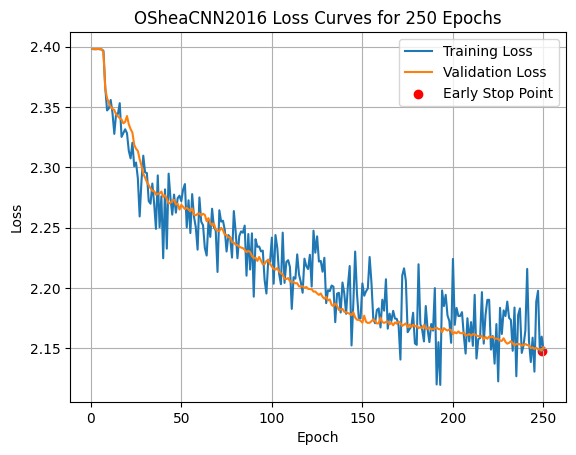

In [49]:
if(not(use_pretrained)): # Generate Loss Curves if Model was Recently Trained
    epoch_idx = np.arange(num_epochs) + 1
    plt.figure()
    plt.title(f'{model.name} Loss Curves for {num_epochs} Epochs')
    plt.plot(epoch_idx,train_loss)
    plt.plot(epoch_idx,val_loss)
    plt.scatter(np.argmin(val_loss)+1,np.min(val_loss),color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend(['Training Loss', 'Validation Loss','Early Stop Point'])
    plt.savefig(f'./results/{model.name}_{num_epochs}_Loss.png')
    plt.show()

In [54]:
# Evaluating Based on SNR Threshold 
if(device == 'cuda'): # Free any Device Memory before Start Training
    torch.cuda.empty_cache()
modelDir = './models/OSheaCNN2016_250_best.pt'
model = torch.load(modelDir)
thresh = 18 # SNR Thresholdh in dB
idxThresh  = np.where(Z_test >= thresh)[0]
eval_data = test_data[idxThresh]
eval_data = torch.utils.data.TensorDataset(*eval_data)
eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
test_acc = models.train.eval(device,model,eval_loader)
print(f'Model Test Accuracy for Samples above {thresh} dB: {test_acc:.2f}')

Model Test Accuracy for Samples above 18 dB: 0.59


In [55]:
# Evaluate Test Accuracies
test_accs = [] 
model = torch.load(modelDir)
for SNR in SNRs:
    idxThresh  = np.where(Z_test >= SNR)[0]
    eval_data = test_data[idxThresh]
    eval_data = torch.utils.data.TensorDataset(*eval_data)
    eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
    test_accs.append(models.train.eval(device,model,eval_loader))

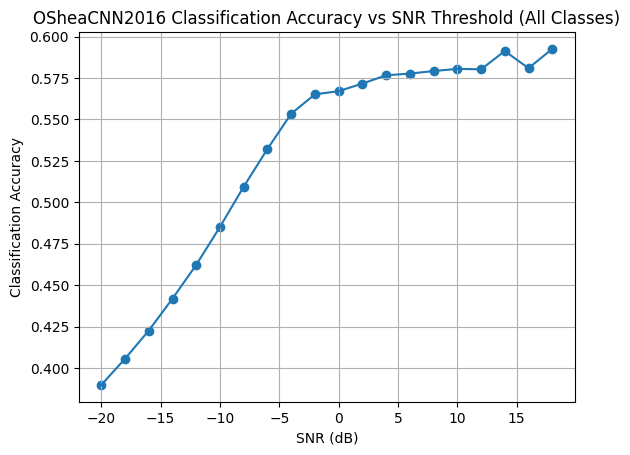

In [56]:
plt.figure()
plt.plot(SNRs,test_accs)
plt.scatter(SNRs,test_accs)
plt.grid()
plt.title(f'{model.name} Classification Accuracy vs SNR Threshold (All Classes)')
plt.xlabel('SNR (dB)')
plt.ylabel('Classification Accuracy')
plt.savefig(f'./results/{os.path.basename(modelDir).split(".pt")[0]}_SNRClassification.png')
plt.show()

## <a name="radio2018">RadioML 2018.01A</a>

Let's load in the RadioML 2018.01A Dataset from [Deepsig](https://deepsig.ai/datasets)! Note that the dataset is around 21 GB, so RAM usage can be upwards of 32 GB.

In [23]:
# Printing Shapes of RadioML 2018.01A
models.datasets.clearDatasetVars(tensors=True)
X,Y,Z,modClasses,SNRs = models.datasets.loadRadioML2018(radioML2018)
print(X.shape)
print(Y.shape)
print(Z.shape)
N = X.shape[0] # Number of Samples

(2555904, 1024, 2)
(2555904, 24)
(2555904, 1)


Below is extraction of some metadata on the class labels and SNRs

In [23]:
# Extracting Variables
labels = np.argmax(Y,axis=-1) # Decode One-Hot Encodings
classes = np.unique(labels)
print("SNRs [dB]: ",SNRs)
print("Classes: ", classes)
print("Classes Names:",modClasses)

SNRs [dB]:  [-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18  20  22  24  26  28  30]
Classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Classes Names: ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']


The RadioML 2018.01A dataset is balanced, meaning there is equal number of labels across each modulation class and an equal amount of labels across each SNR level.

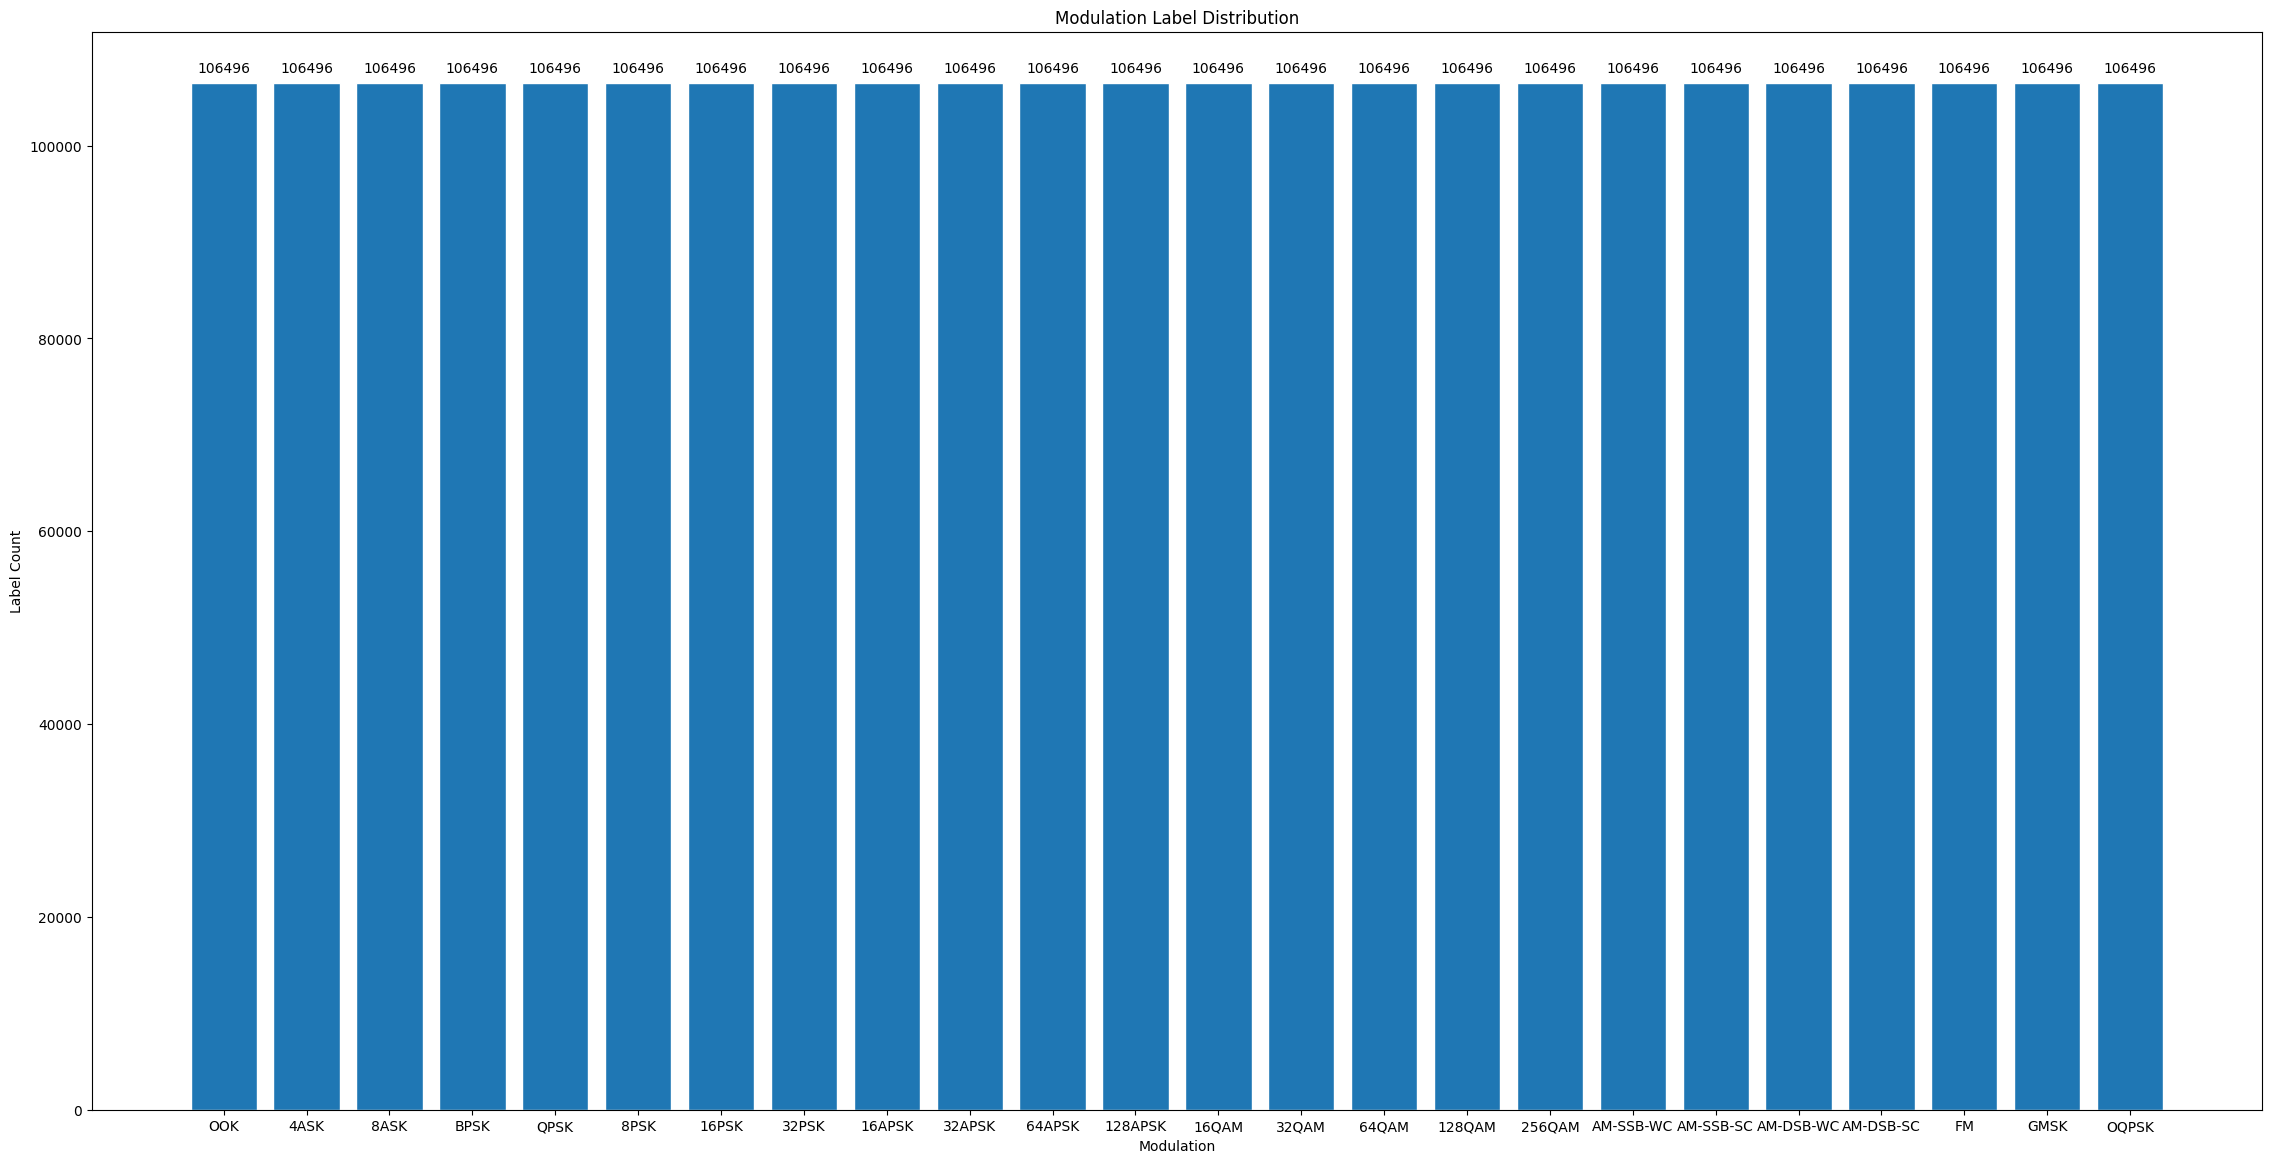

In [24]:
# Label Distribution across Modulation Classes
plt.figure(figsize=(28,14))
counts, bins = np.histogram(labels,bins=len(classes))
trainTitle = plt.title('RadioML 2018.01A Modulation Label Distribution')
trainXLabel = plt.xlabel('Modulation')
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(modClasses,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')
plt.savefig('./results/RadioML2018_ModLabelDist.png')
plt.show()

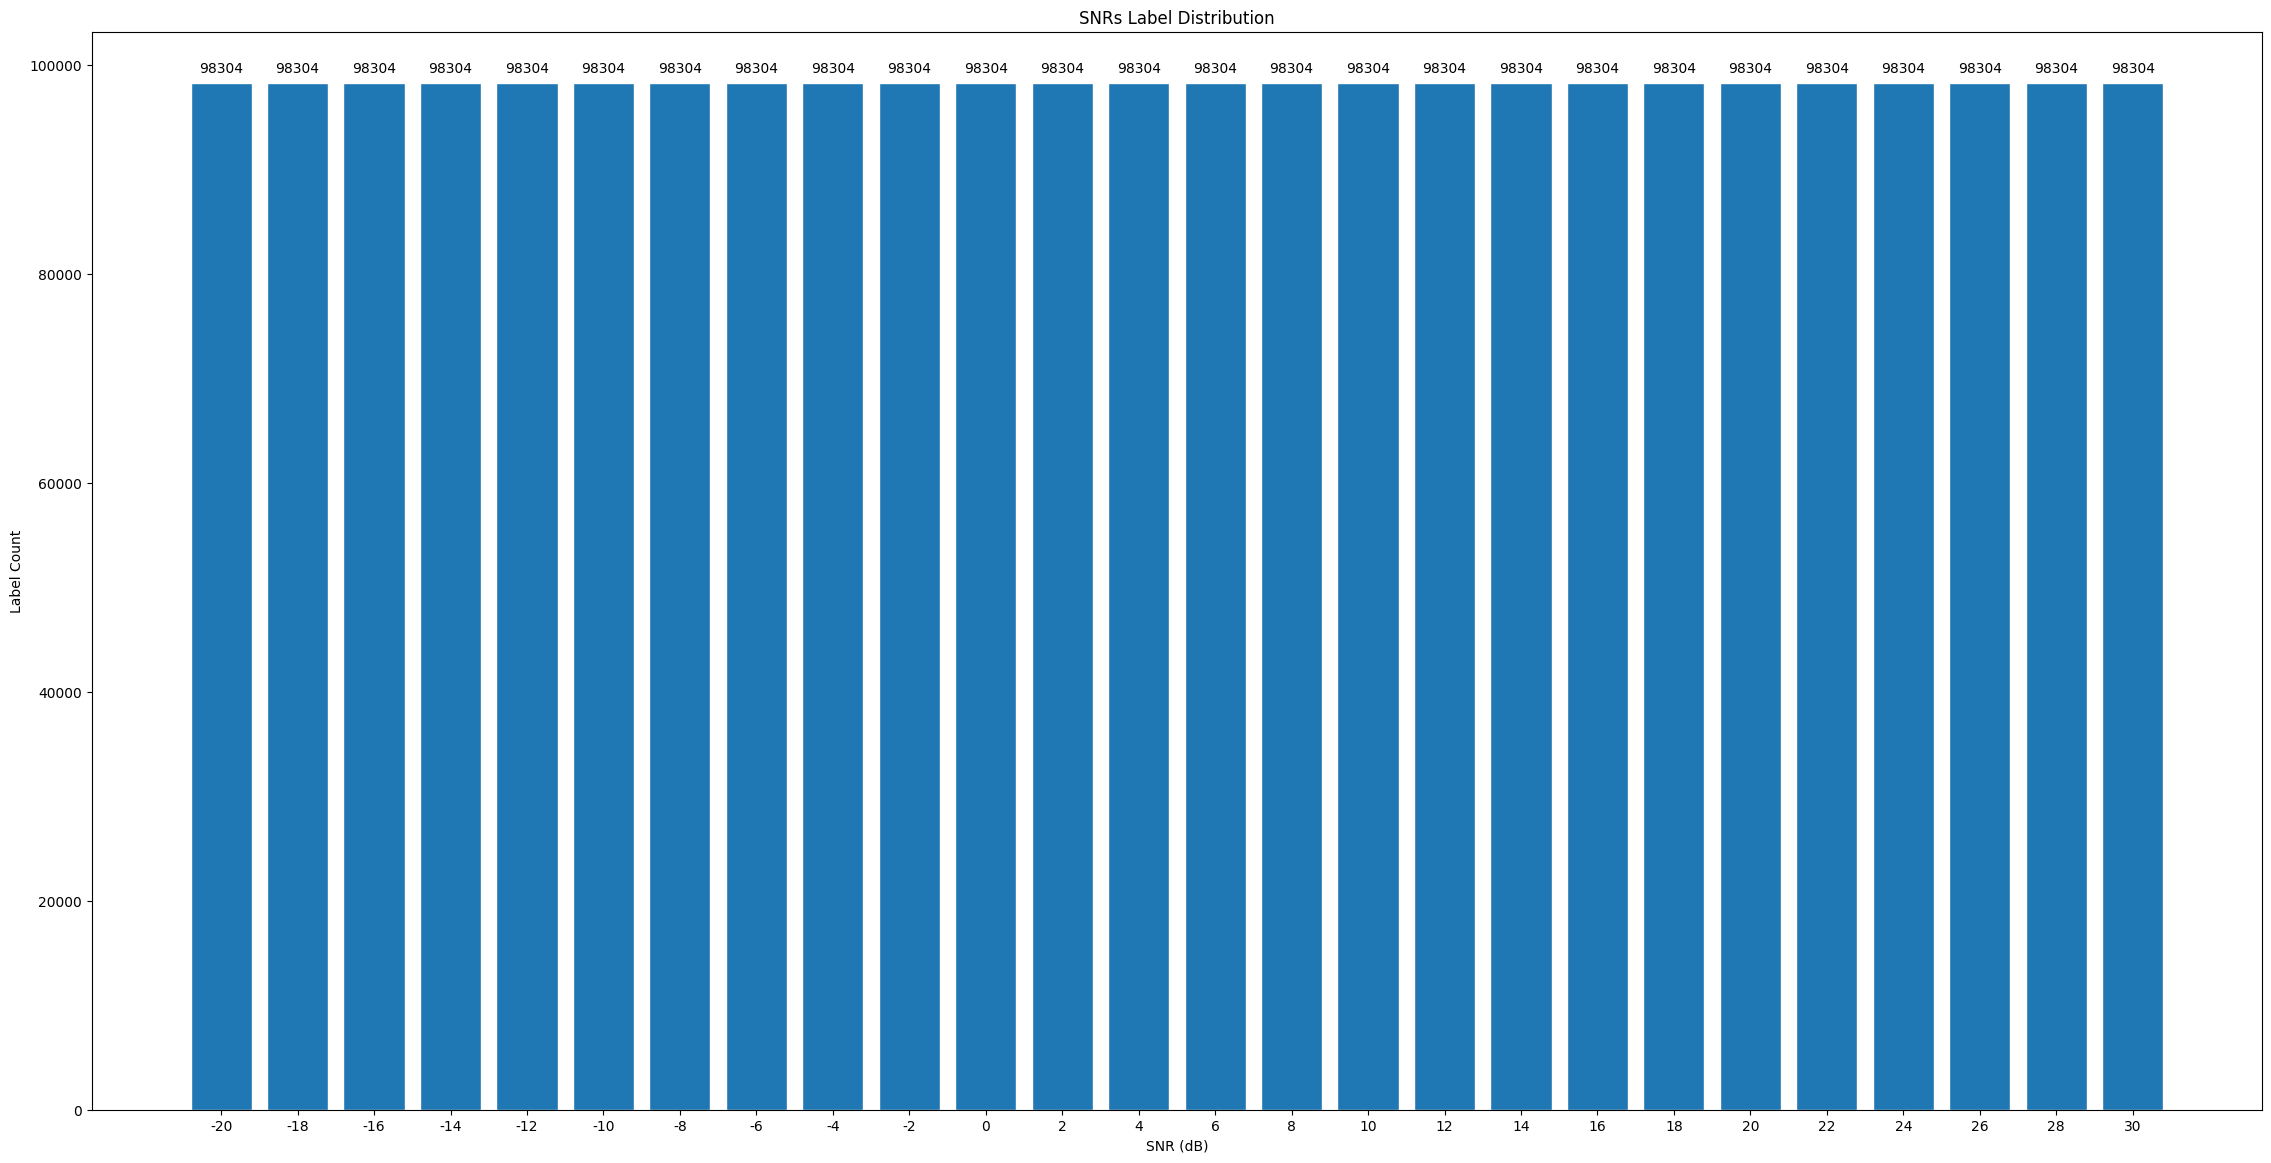

In [25]:
# Label Distribution across SNRs
SNRs_str = [str(SNR) for SNR in SNRs]
plt.figure(figsize=(28,14))
counts, bins = np.histogram(Z,bins=len(SNRs))
trainTitle = plt.title('RadioML 2018.01A SNRs Label Distribution')
trainXLabel = plt.xlabel('SNR (dB)')
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(SNRs_str,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')
plt.savefig('./results/RadioML2018_SNRLabelDist.png')
plt.show()

Here a single IQ signal is viewed as a temporal sequence as well as its constellation.

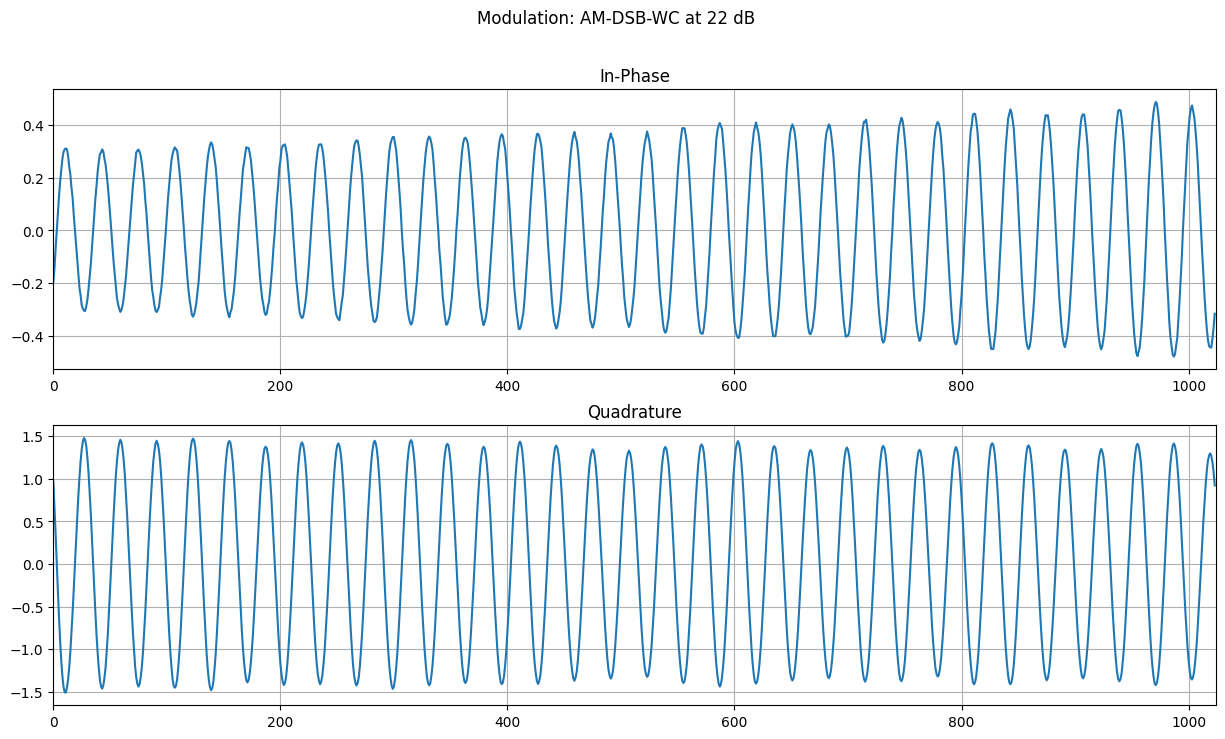

In [26]:
# IQ Temporal Sequence
index = 2110000
plt.figure(figsize=(15,8))
plt.suptitle(f'Modulation: {modClasses[labels[index]]} at {Z[index][0]} dB')
plt.subplot(2,1,1)
plt.title('In-Phase')
plt.grid()
plt.plot(X[index,:,0])
plt.xlim(0,X.shape[1])
plt.subplot(2,1,2)
plt.grid()
plt.title('Quadrature')
plt.plot(X[index,:,1])
plt.xlim(0,X.shape[1])
plt.savefig(f'./results/RadioML2018_{index}_Temporal.png')
plt.show()

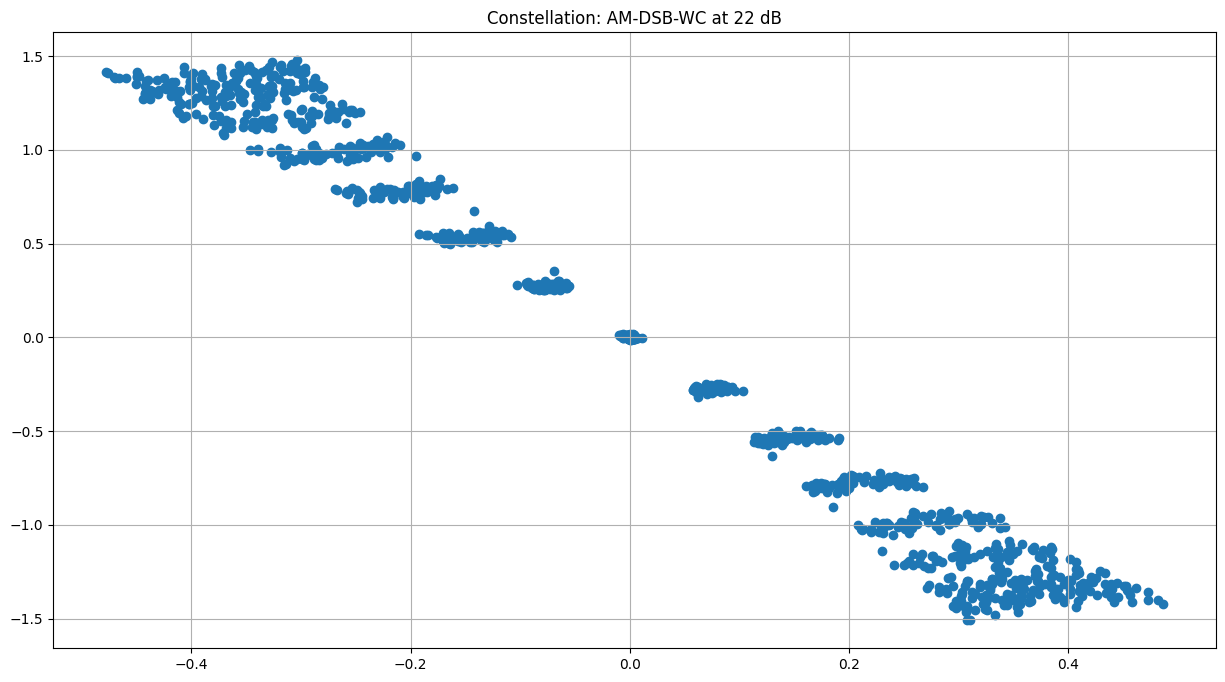

In [27]:
# Constellatino Visualization
plt.figure(figsize=(15,8))
plt.title(f'Constellation: {modClasses[labels[index]]} at {Z[index][0]} dB')
plt.scatter(X[index,:,0],X[index,:,1])
plt.grid()
plt.savefig(f'./results/RadioML2018_{index}_Constellation.png')
plt.show()

### Data Preparation 

The RadioML 2018.01A data is prepared into tensors such that they can be used to train a neural network with the accleration of GPUs. 

In [13]:
# Split Data into Train,Val,Test Subsets (90-5-5)%

# Warning: Memory Intensive (Can Take Upwards of 64 GB)
split = np.array([90,5,5])/100
batch_size = 9000
clearDatasetVars(tensors=True)
X,Y,Z,modClasses,SNRs = models.datasets.loadRadioML2018(radioML2018)
train_data,val_data,test_data,train_loader,val_loader,test_loader,Z_test = models.datasets.prepareDatasetRadioML(X,Y,Z,split,batch_size)

# Freeing Memory of Intermediate Values
clearDatasetVars(tensors=False,verbose=True)

Deleted X
Deleted Y
Deleted Z


### Model Training and Evaluation

This section covers the training of the neural network to achieve high classification accuracy at high SNRs.

In [83]:
use_pretrained = False

# Define the loss function 
criterion = nn.CrossEntropyLoss()

if(use_pretrained): # Evaluate Pre-Trained Models
    modelDir = './models/OSheaCNN2018_100_best.pt'
    model = torch.load(modelDir)
    test_acc =  models.train.eval(device,model,test_loader)
    print(f'Overall Test Acc: {test_acc:.3f}')
else: # Training Model
    model = OSheaCNN2018().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-4)
    num_epochs = 3
    if(device == 'cuda'): # Free any Device Memory before Start Training
        torch.cuda.empty_cache()
    train_loss, val_loss, min_val_loss, best_model =  models.train.train_earlystop(device,model,criterion,optimizer,train_loader,val_loader,test_loader,num_epochs)
    torch.save(model,f'./models/OSheaCNN2018_{num_epochs}_last.pt')
    torch.save(best_model,f'./models/OSheaCNN2018_{num_epochs}_best.pt')
    test_last_acc = models.train.eval(device,model,test_loader)
    test_best_acc = models.train.eval(device,best_model,test_loader)
    print(f'\nOverall Test Acc (Last Epoch): {test_last_acc:.3f}')
    print(f'Overall Test Acc (Best Val): {test_best_acc:.3f}')

Overall Test Acc: 0.574


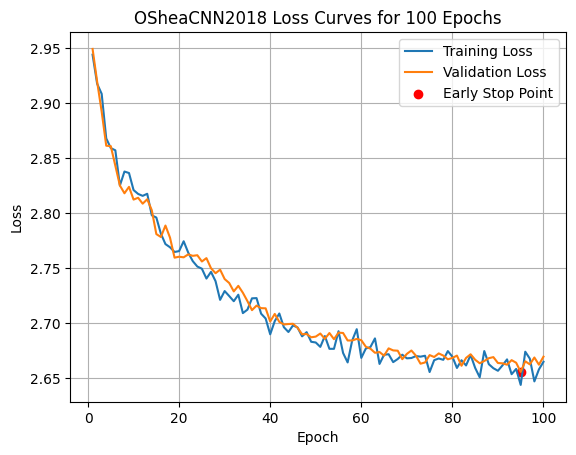

In [112]:
if(not(use_pretrained)): # Generate Loss Curves if Model was Recently Trained
    epoch_idx = np.arange(num_epochs) + 1
    plt.figure()
    plt.title(f'{model.name} Loss Curves for {num_epochs} Epochs')
    plt.plot(epoch_idx,train_loss)
    plt.plot(epoch_idx,val_loss)
    plt.scatter(np.argmin(val_loss)+1,np.min(val_loss),color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend(['Training Loss', 'Validation Loss','Early Stop Point'])
    plt.savefig(f'./results/{model.name}_{num_epochs}_Loss.png')
    plt.show()

In [113]:
# Evaluating Based on SNR Threshold 
if(device == 'cuda'): # Free any Device Memory before Start Training
    torch.cuda.empty_cache()
modelDir = './models/OSheaCNN2018_100_best.pt'
model = torch.load(modelDir)
thresh = 20 # SNR Thresholdh in dB
idxThresh  = np.where(Z_test >= thresh)[0]
eval_data = test_data[idxThresh]
eval_data = torch.utils.data.TensorDataset(*eval_data)
eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
test_acc = models.train.eval(device,model,eval_loader)
print(f'Model Test Accuracy for Samples above {thresh} dB: {test_acc:.2f}')

Model Test Accuracy for Samples above 20 dB: 0.90


In [114]:
# Evaluate Test Accuracies
test_accs = [] 
model = torch.load(modelDir)
for SNR in SNRs:
    idxThresh  = np.where(Z_test >= SNR)[0]
    eval_data = test_data[idxThresh]
    eval_data = torch.utils.data.TensorDataset(*eval_data)
    eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
    test_accs.append(models.train.eval(device,model,eval_loader))

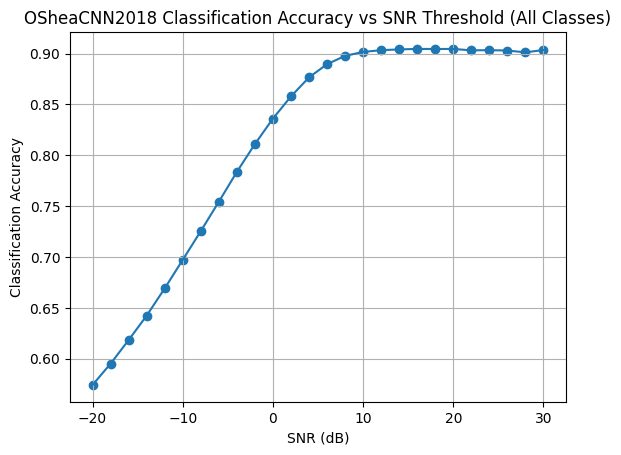

In [119]:
plt.figure()
plt.plot(SNRs,test_accs)
plt.scatter(SNRs,test_accs)
plt.grid()
plt.title(f'{model.name} Classification Accuracy vs SNR Threshold (All Classes)')
plt.xlabel('SNR (dB)')
plt.ylabel('Classification Accuracy')
plt.savefig(f'./results/{os.path.basename(modelDir).split(".pt")[0]}_SNRClassification.png')
plt.show()

## <a name="hisar2019">HisarMod 2019.1</a>

### Data Conversion

We first convert the dataset into a readable format in Python. By default the data CSVs (i.e., <code>train_data.csv</code> & <code>test_data.csv</code>) comes in a format where each cell is in the format **a + bi**, which isn't effciently readable by default by Python. Thus, we employ MATLAB (the same program that created the dataset), to convert the data into a 3D tensor for the IQ Matrices with the custom script <code>convertHisarToPython.m<code>.

In [3]:
# Run the MATLAB Conversion Process if Data Hasn't Been Converted from CSV yet
trainMat = f'{hisar2019Dir}/HisarMod2019.1/Train/train_data.mat'
testMat = f'{hisar2019Dir}/HisarMod2019.1/Test/test_data.mat'
if(not(os.path.exists(trainMat)) or not(os.path.exists(testMat))):
   eng = matlab.engine.start_matlab()
   eng.convertHisarToPython()

### Data Visualization

In [4]:
# Printing Shapes of Hisar2019 (Warning: Dataset loading can take upwards of 20 GB and around a minute to run)
clearDatasetVars(tensors=True)
X_train_val,X_test,Y_train_val,Y_test,Z_train_val,Z_test,SNRs,modClasses =  models.datasets.loadHisar(hisar2019Dir)
print(X_train_val.shape)
print(X_test.shape)
print(Y_train_val.shape)
print(Y_test.shape)
print(Z_train_val.shape)
print(Z_test.shape)

(520000, 1024, 2)
(260000, 1024, 2)
(520000, 26)
(260000, 26)
(520000,)
(260000,)


In [6]:
# Extracting Variables of Train Val Set
labels = np.argmax(Y_train_val,axis=-1) # Decode One-Hot Encodings
classes = np.unique(labels)
print("SNRs [dB]: ",SNRs)
print("Classes: ", classes)
print("Classes Names:",modClasses)

SNRs [dB]:  [-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.
   8.  10.  12.  14.  16.  18.]
Classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Classes Names: ['BPQK', 'QPSK', '8PSK', '16PSK', '32PSK', '64PSK', '4QAM', '8QAM', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', '2FSK', '4FSK', '8FSK', '16FSK', '4PAM', '8PAM', '16PAM', 'AM-DB', 'AM-DB-SC', 'AM-USB', 'AM-LSB', 'FM', 'PM']


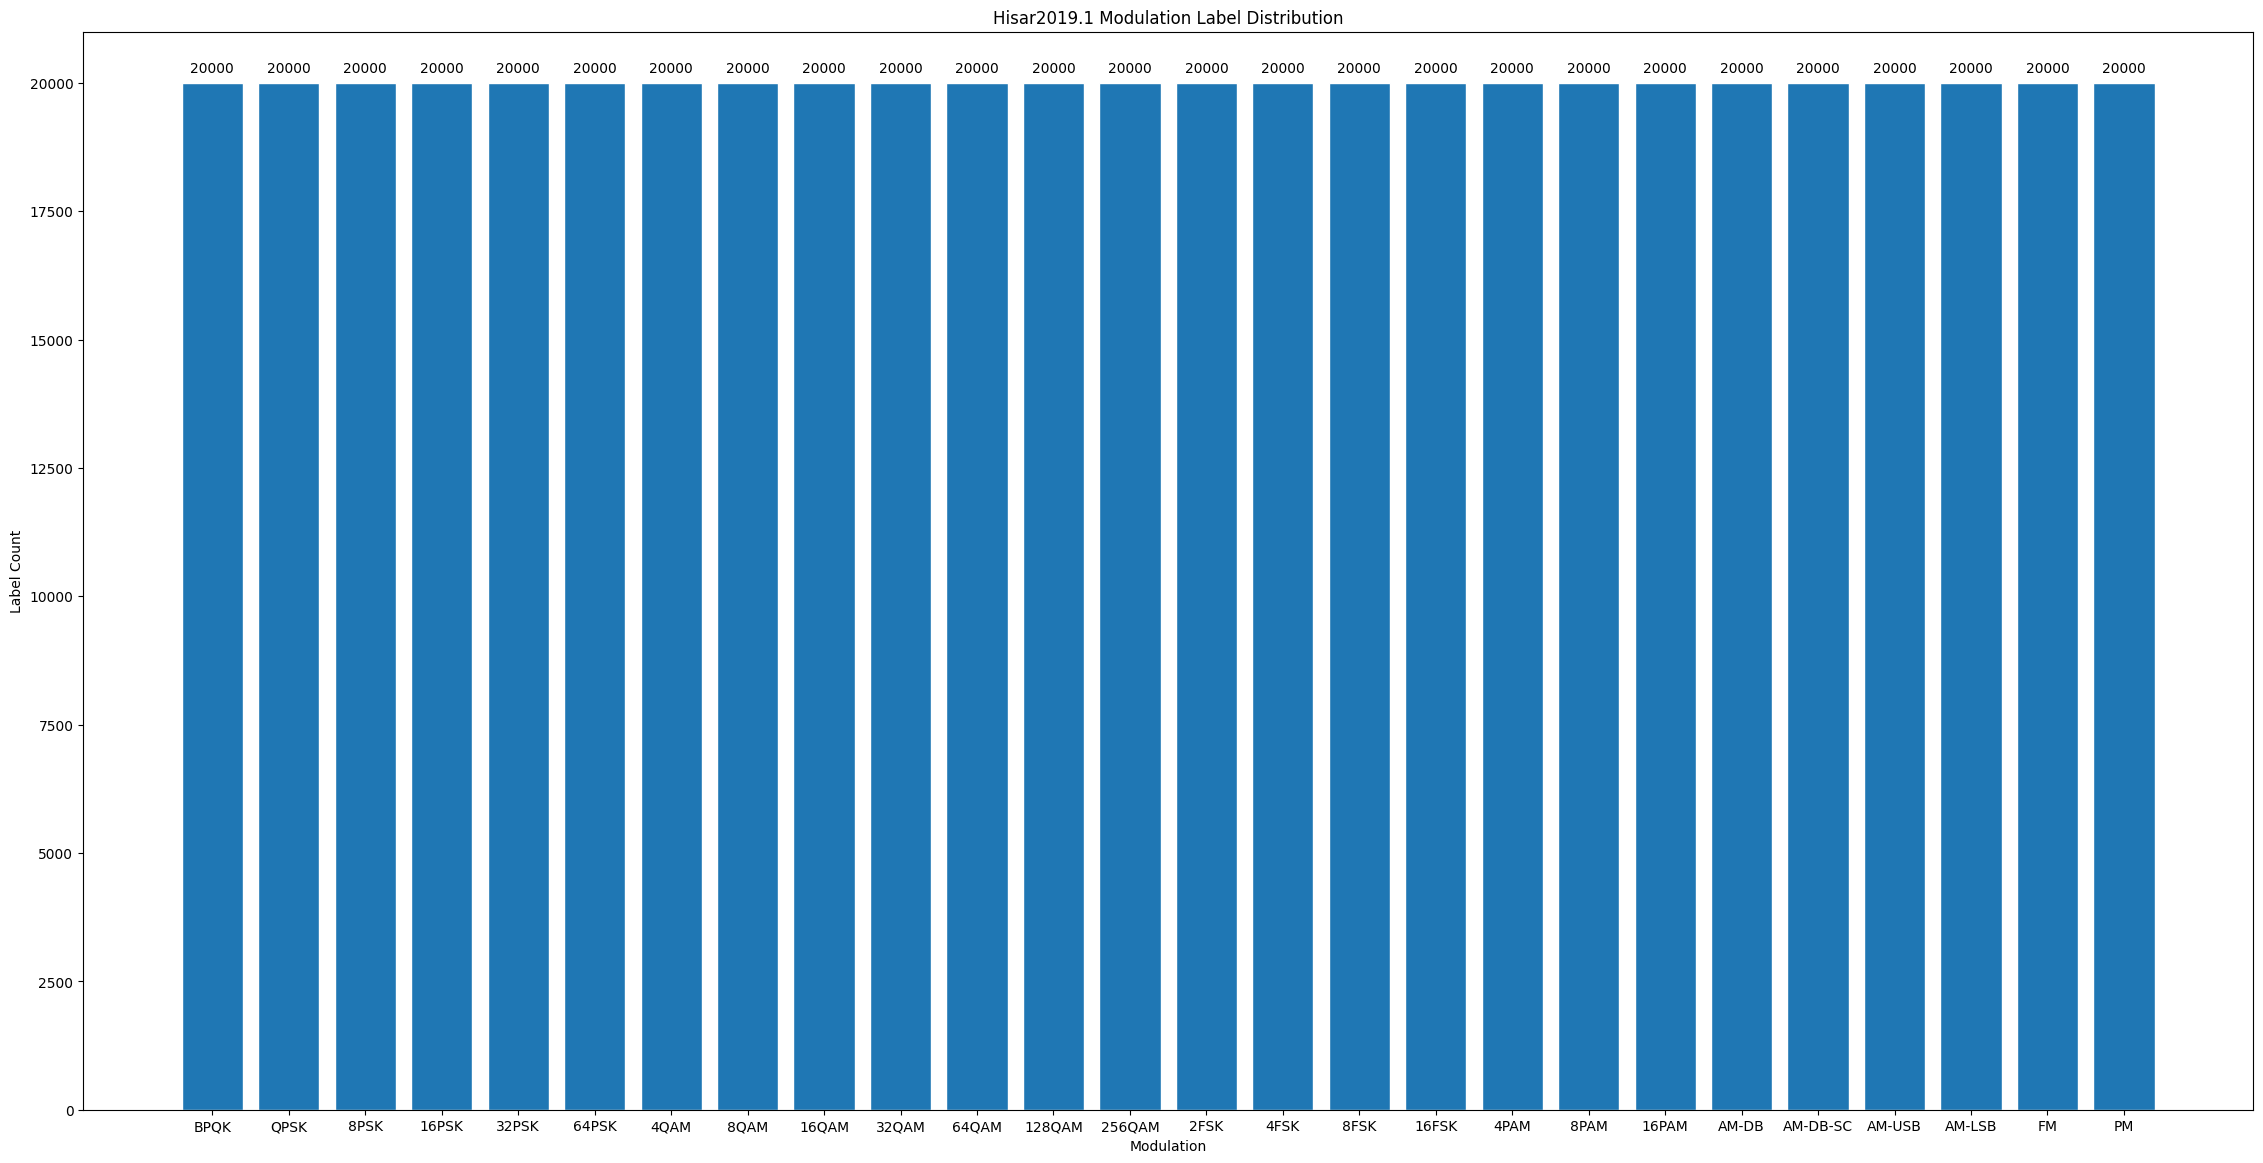

In [18]:
# Label Distribution across Modulation Classes for Train Val Subset
plt.figure(figsize=(28,14))
counts, bins = np.histogram(labels,bins=len(classes))
trainTitle = plt.title('Hisar2019.1 Modulation Label Distribution')
trainXLabel = plt.xlabel('Modulation')
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(modClasses,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')
plt.savefig('./results/Hisar2019_ModLabelDist.png')
plt.show()

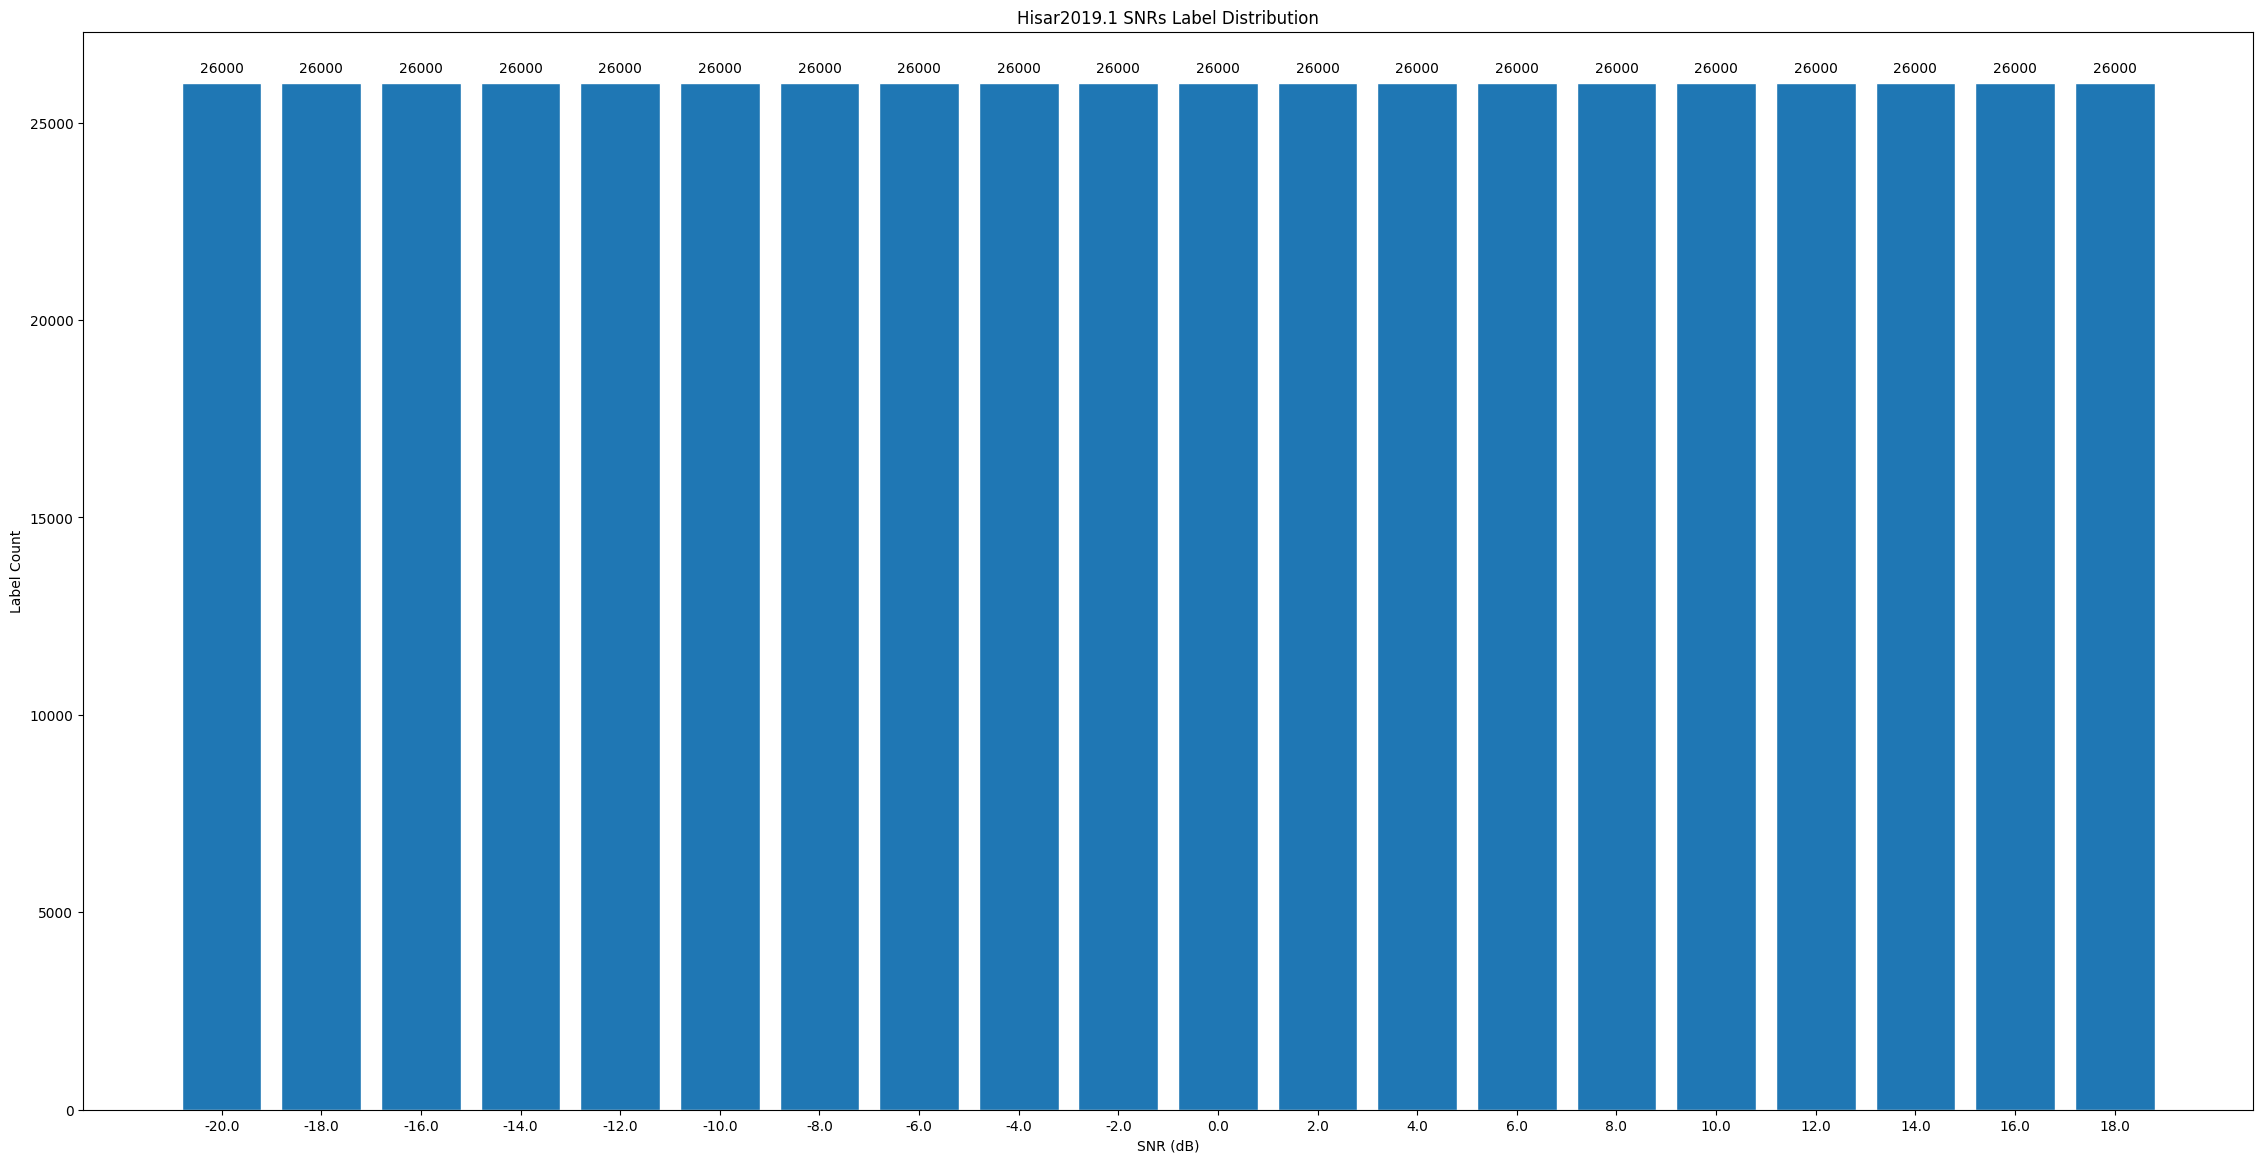

In [17]:
# Label Distribution across SNRs for Train Val Subset 
SNRs_str = [str(SNR) for SNR in SNRs]
plt.figure(figsize=(28,14))
counts, bins = np.histogram(Z_train_val,bins=len(SNRs))
trainTitle = plt.title('Hisar2019.1 SNRs Label Distribution')
trainXLabel = plt.xlabel('SNR (dB)')
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(SNRs_str,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')
plt.savefig('./results/Hisar2019_SNRLabelDist.png')
plt.show()

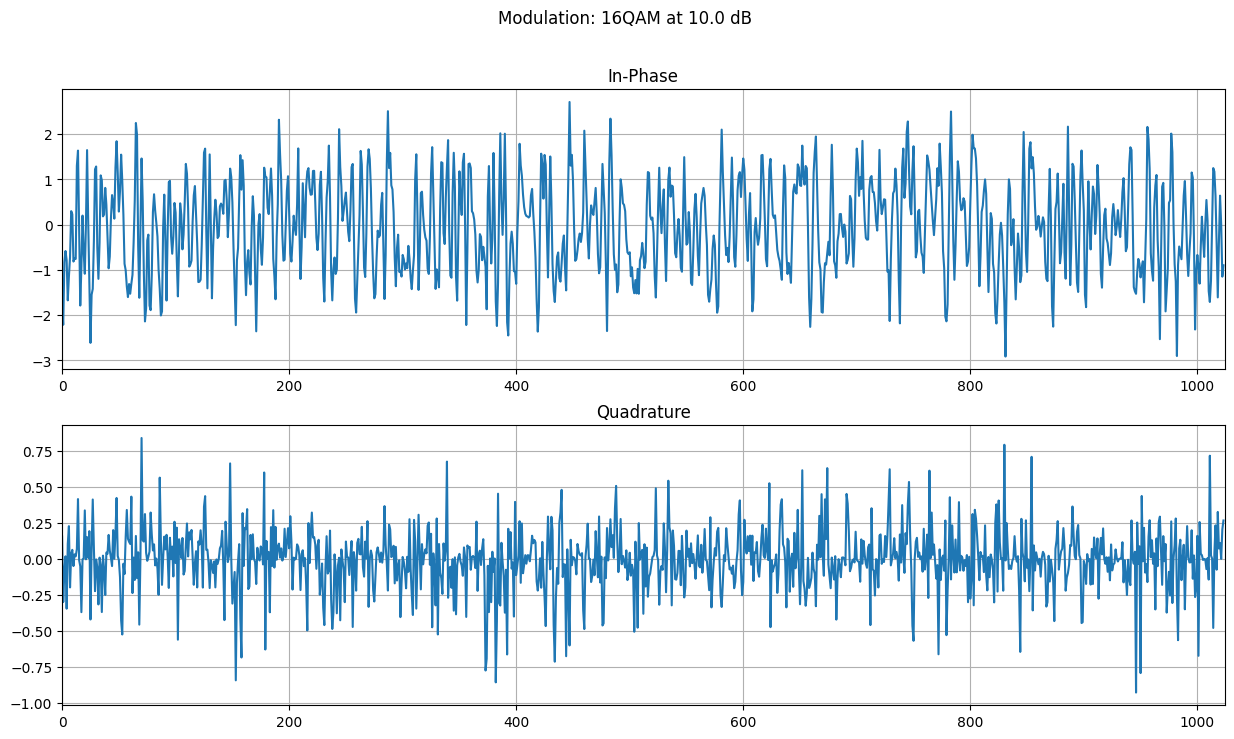

In [19]:
# IQ Temporal Sequence in Train Val Subset
index = 400000
plt.figure(figsize=(15,8))
plt.suptitle(f'Modulation: {modClasses[labels[index]]} at {Z_train_val[index]} dB')
plt.subplot(2,1,1)
plt.title('In-Phase')
plt.grid()
plt.plot(X_train_val[index,:,0])
plt.xlim(0,X_train_val.shape[1])
plt.subplot(2,1,2)
plt.grid()
plt.title('Quadrature')
plt.plot(X_train_val[index,:,1])
plt.xlim(0,X_train_val.shape[1])
plt.savefig(f'./results/Hisar2019_{index}_Temporal.png')
plt.show()

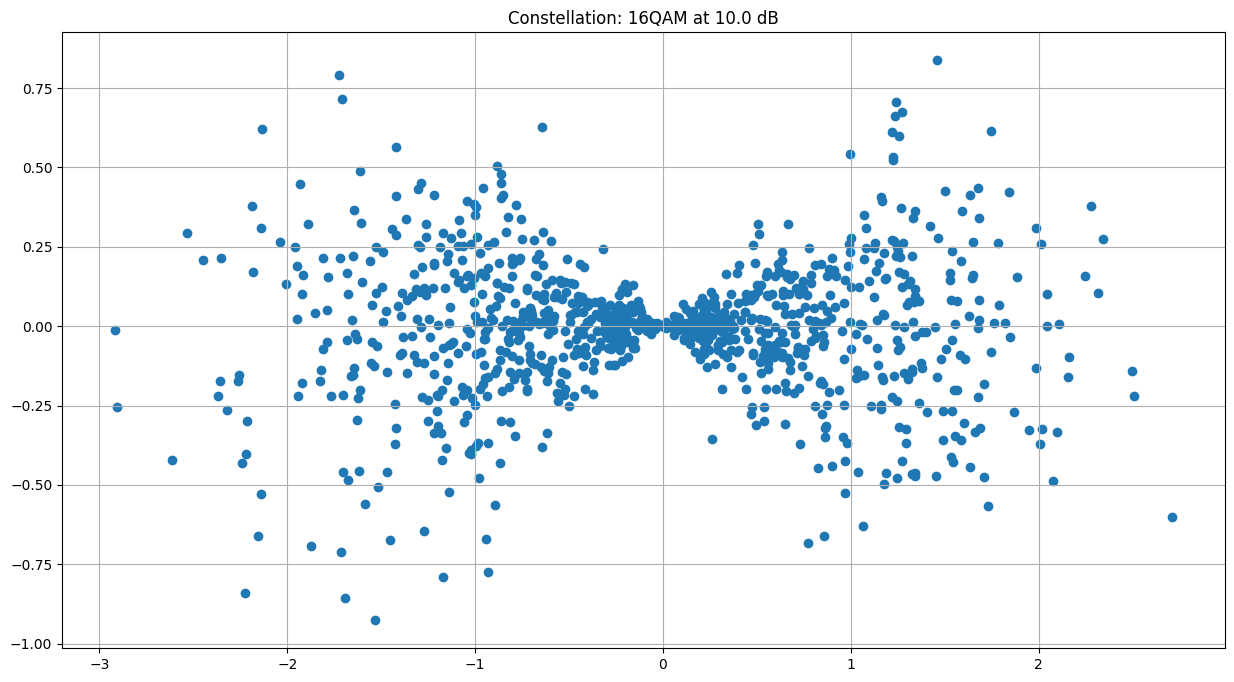

In [20]:
# Constellation Visualization in Train Val Subset
plt.figure(figsize=(15,8))
plt.title(f'Constellation: {modClasses[labels[index]]} at {Z_train_val[index]} dB')
plt.scatter(X_train_val[index,:,0],X_train_val[index,:,1])
plt.grid()
plt.savefig(f'./results/Hisar2019_{index}_Constellation.png')
plt.show()

### Data Preperation

In [10]:
# Split Data into Train,Val into (80-20)%, Test Set is Already Seperate

# Warning: Memory Intensive (Can Take Upwards of 32 GB) & Can Take a Few Mins to Load
split = np.array([80,20])/100
batch_size = 9000
clearDatasetVars(tensors=True)
X_train_val,X_test,Y_train_val,Y_test,Z_train_val,Z_test,SNRs,modClasses =  models.datasets.loadHisar(hisar2019Dir)
train_data,val_data,test_data,train_loader,val_loader,test_loader = models.datasets.prepareDatasetHisar(X_train_val,X_test,Y_train_val,Y_test,split,batch_size)

# Freeing Memory of Intermediate Values
clearDatasetVars(tensors=False)

### Model Training and Evaluation

In [23]:
use_pretrained = False

# Define the loss function 
criterion = nn.CrossEntropyLoss()

if(use_pretrained): # Evaluate Pre-Trained Models
    modelDir = './models/HisarCNN2019_100_best.pt'
    model = torch.load(modelDir)
    test_acc =  models.train.eval(device,model,test_loader)
    print(f'Overall Test Acc: {test_acc:.3f}')
else: # Training Model
    model = HisarCNN2019().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-4)
    num_epochs = 100
    if(device == 'cuda'): # Free any Device Memory before Start Training
        torch.cuda.empty_cache()
    train_loss, val_loss, min_val_loss, best_model =  models.train.train_earlystop(device,model,criterion,optimizer,train_loader,val_loader,test_loader,num_epochs)
    torch.save(model,f'./models/HisarCNN2019_{num_epochs}_last.pt')
    torch.save(best_model,f'./models/HisarCNN2019_{num_epochs}_best.pt')
    test_last_acc = models.train.eval(device,model,test_loader)
    test_best_acc = models.train.eval(device,best_model,test_loader)
    print(f'\nOverall Test Acc (Last Epoch): {test_last_acc:.3f}')
    print(f'Overall Test Acc (Best Val): {test_best_acc:.3f}')


Starting to Train HisarCNN2019 for 100 Epochs!


  1%|▊                                                                                 | 1/100 [00:08<13:37,  8.26s/it]

Epoch [1/100]: Train Loss: 3.101 Val Loss: 3.102 Train Acc: 0.135, Val Acc: 0.206


  2%|█▋                                                                                | 2/100 [00:16<13:09,  8.06s/it]

Epoch [2/100]: Train Loss: 3.087 Val Loss: 3.071 Train Acc: 0.224, Val Acc: 0.246


  3%|██▍                                                                               | 3/100 [00:24<12:54,  7.98s/it]

Epoch [3/100]: Train Loss: 3.027 Val Loss: 3.045 Train Acc: 0.267, Val Acc: 0.267


  4%|███▎                                                                              | 4/100 [00:31<12:38,  7.90s/it]

Epoch [4/100]: Train Loss: 3.012 Val Loss: 3.023 Train Acc: 0.289, Val Acc: 0.289


  5%|████                                                                              | 5/100 [00:39<12:32,  7.92s/it]

Epoch [5/100]: Train Loss: 2.985 Val Loss: 3.031 Train Acc: 0.297, Val Acc: 0.282


  6%|████▉                                                                             | 6/100 [00:47<12:22,  7.89s/it]

Epoch [6/100]: Train Loss: 3.000 Val Loss: 3.022 Train Acc: 0.297, Val Acc: 0.292


  7%|█████▋                                                                            | 7/100 [00:55<12:11,  7.87s/it]

Epoch [7/100]: Train Loss: 2.993 Val Loss: 3.013 Train Acc: 0.307, Val Acc: 0.307


  8%|██████▌                                                                           | 8/100 [01:03<12:06,  7.89s/it]

Epoch [8/100]: Train Loss: 2.985 Val Loss: 3.009 Train Acc: 0.314, Val Acc: 0.309


  9%|███████▍                                                                          | 9/100 [01:11<11:57,  7.89s/it]

Epoch [9/100]: Train Loss: 2.994 Val Loss: 2.998 Train Acc: 0.317, Val Acc: 0.323


 10%|████████                                                                         | 10/100 [01:19<11:47,  7.86s/it]

Epoch [10/100]: Train Loss: 2.978 Val Loss: 3.008 Train Acc: 0.329, Val Acc: 0.314


 11%|████████▉                                                                        | 11/100 [01:27<11:42,  7.89s/it]

Epoch [11/100]: Train Loss: 2.970 Val Loss: 2.988 Train Acc: 0.331, Val Acc: 0.331


 12%|█████████▋                                                                       | 12/100 [01:35<11:48,  8.05s/it]

Epoch [12/100]: Train Loss: 2.979 Val Loss: 2.990 Train Acc: 0.339, Val Acc: 0.333


 13%|██████████▌                                                                      | 13/100 [01:43<11:52,  8.19s/it]

Epoch [13/100]: Train Loss: 2.968 Val Loss: 2.972 Train Acc: 0.341, Val Acc: 0.344


 14%|███████████▎                                                                     | 14/100 [01:52<11:45,  8.20s/it]

Epoch [14/100]: Train Loss: 2.967 Val Loss: 2.973 Train Acc: 0.350, Val Acc: 0.347


 15%|████████████▏                                                                    | 15/100 [02:00<11:42,  8.26s/it]

Epoch [15/100]: Train Loss: 2.976 Val Loss: 2.977 Train Acc: 0.351, Val Acc: 0.343


 16%|████████████▉                                                                    | 16/100 [02:08<11:35,  8.28s/it]

Epoch [16/100]: Train Loss: 2.952 Val Loss: 2.965 Train Acc: 0.354, Val Acc: 0.352


 17%|█████████████▊                                                                   | 17/100 [02:16<11:18,  8.18s/it]

Epoch [17/100]: Train Loss: 2.952 Val Loss: 2.978 Train Acc: 0.359, Val Acc: 0.346


 18%|██████████████▌                                                                  | 18/100 [02:24<11:03,  8.09s/it]

Epoch [18/100]: Train Loss: 2.949 Val Loss: 2.960 Train Acc: 0.364, Val Acc: 0.356


 19%|███████████████▍                                                                 | 19/100 [02:32<10:48,  8.00s/it]

Epoch [19/100]: Train Loss: 2.955 Val Loss: 2.972 Train Acc: 0.367, Val Acc: 0.350


 20%|████████████████▏                                                                | 20/100 [02:40<10:40,  8.00s/it]

Epoch [20/100]: Train Loss: 2.962 Val Loss: 2.950 Train Acc: 0.370, Val Acc: 0.366


 21%|█████████████████                                                                | 21/100 [02:48<10:31,  7.99s/it]

Epoch [21/100]: Train Loss: 2.928 Val Loss: 2.946 Train Acc: 0.373, Val Acc: 0.372


 22%|█████████████████▊                                                               | 22/100 [02:56<10:19,  7.94s/it]

Epoch [22/100]: Train Loss: 2.940 Val Loss: 2.948 Train Acc: 0.374, Val Acc: 0.369


 23%|██████████████████▋                                                              | 23/100 [03:04<10:12,  7.95s/it]

Epoch [23/100]: Train Loss: 2.931 Val Loss: 2.940 Train Acc: 0.385, Val Acc: 0.378


 24%|███████████████████▍                                                             | 24/100 [03:12<10:03,  7.94s/it]

Epoch [24/100]: Train Loss: 2.913 Val Loss: 2.936 Train Acc: 0.390, Val Acc: 0.384


 25%|████████████████████▎                                                            | 25/100 [03:20<09:53,  7.91s/it]

Epoch [25/100]: Train Loss: 2.936 Val Loss: 2.940 Train Acc: 0.396, Val Acc: 0.378


 26%|█████████████████████                                                            | 26/100 [03:28<09:46,  7.93s/it]

Epoch [26/100]: Train Loss: 2.915 Val Loss: 2.937 Train Acc: 0.402, Val Acc: 0.379


 27%|█████████████████████▊                                                           | 27/100 [03:35<09:38,  7.92s/it]

Epoch [27/100]: Train Loss: 2.936 Val Loss: 2.939 Train Acc: 0.403, Val Acc: 0.375


 28%|██████████████████████▋                                                          | 28/100 [03:43<09:28,  7.89s/it]

Epoch [28/100]: Train Loss: 2.906 Val Loss: 2.931 Train Acc: 0.405, Val Acc: 0.390


 29%|███████████████████████▍                                                         | 29/100 [03:51<09:21,  7.91s/it]

Epoch [29/100]: Train Loss: 2.917 Val Loss: 2.916 Train Acc: 0.413, Val Acc: 0.402


 30%|████████████████████████▎                                                        | 30/100 [03:59<09:12,  7.90s/it]

Epoch [30/100]: Train Loss: 2.908 Val Loss: 2.922 Train Acc: 0.415, Val Acc: 0.391


 31%|█████████████████████████                                                        | 31/100 [04:07<09:09,  7.96s/it]

Epoch [31/100]: Train Loss: 2.910 Val Loss: 2.902 Train Acc: 0.424, Val Acc: 0.414


 32%|█████████████████████████▉                                                       | 32/100 [04:16<09:15,  8.16s/it]

Epoch [32/100]: Train Loss: 2.899 Val Loss: 2.902 Train Acc: 0.434, Val Acc: 0.415


 33%|██████████████████████████▋                                                      | 33/100 [04:24<09:10,  8.22s/it]

Epoch [33/100]: Train Loss: 2.883 Val Loss: 2.892 Train Acc: 0.434, Val Acc: 0.423


 34%|███████████████████████████▌                                                     | 34/100 [04:32<08:57,  8.15s/it]

Epoch [34/100]: Train Loss: 2.886 Val Loss: 2.904 Train Acc: 0.437, Val Acc: 0.416


 35%|████████████████████████████▎                                                    | 35/100 [04:40<08:46,  8.10s/it]

Epoch [35/100]: Train Loss: 2.877 Val Loss: 2.892 Train Acc: 0.441, Val Acc: 0.430


 36%|█████████████████████████████▏                                                   | 36/100 [04:48<08:36,  8.07s/it]

Epoch [36/100]: Train Loss: 2.890 Val Loss: 2.899 Train Acc: 0.442, Val Acc: 0.416


 37%|█████████████████████████████▉                                                   | 37/100 [04:56<08:31,  8.11s/it]

Epoch [37/100]: Train Loss: 2.867 Val Loss: 2.896 Train Acc: 0.445, Val Acc: 0.419


 38%|██████████████████████████████▊                                                  | 38/100 [05:05<08:32,  8.26s/it]

Epoch [38/100]: Train Loss: 2.874 Val Loss: 2.881 Train Acc: 0.454, Val Acc: 0.434


 39%|███████████████████████████████▌                                                 | 39/100 [05:13<08:22,  8.24s/it]

Epoch [39/100]: Train Loss: 2.861 Val Loss: 2.873 Train Acc: 0.455, Val Acc: 0.440


 40%|████████████████████████████████▍                                                | 40/100 [05:21<08:08,  8.13s/it]

Epoch [40/100]: Train Loss: 2.854 Val Loss: 2.887 Train Acc: 0.462, Val Acc: 0.430


 41%|█████████████████████████████████▏                                               | 41/100 [05:29<07:56,  8.07s/it]

Epoch [41/100]: Train Loss: 2.864 Val Loss: 2.870 Train Acc: 0.463, Val Acc: 0.445


 42%|██████████████████████████████████                                               | 42/100 [05:37<07:44,  8.01s/it]

Epoch [42/100]: Train Loss: 2.859 Val Loss: 2.875 Train Acc: 0.469, Val Acc: 0.441


 43%|██████████████████████████████████▊                                              | 43/100 [05:45<07:32,  7.94s/it]

Epoch [43/100]: Train Loss: 2.843 Val Loss: 2.885 Train Acc: 0.471, Val Acc: 0.434


 44%|███████████████████████████████████▋                                             | 44/100 [05:53<07:23,  7.93s/it]

Epoch [44/100]: Train Loss: 2.848 Val Loss: 2.865 Train Acc: 0.471, Val Acc: 0.451


 45%|████████████████████████████████████▍                                            | 45/100 [06:00<07:15,  7.93s/it]

Epoch [45/100]: Train Loss: 2.840 Val Loss: 2.863 Train Acc: 0.476, Val Acc: 0.450


 46%|█████████████████████████████████████▎                                           | 46/100 [06:08<07:06,  7.89s/it]

Epoch [46/100]: Train Loss: 2.856 Val Loss: 2.861 Train Acc: 0.483, Val Acc: 0.455


 47%|██████████████████████████████████████                                           | 47/100 [06:16<06:58,  7.90s/it]

Epoch [47/100]: Train Loss: 2.833 Val Loss: 2.859 Train Acc: 0.480, Val Acc: 0.457


 48%|██████████████████████████████████████▉                                          | 48/100 [06:24<06:50,  7.89s/it]

Epoch [48/100]: Train Loss: 2.832 Val Loss: 2.863 Train Acc: 0.485, Val Acc: 0.453


 49%|███████████████████████████████████████▋                                         | 49/100 [06:32<06:41,  7.86s/it]

Epoch [49/100]: Train Loss: 2.842 Val Loss: 2.857 Train Acc: 0.487, Val Acc: 0.459


 50%|████████████████████████████████████████▌                                        | 50/100 [06:40<06:33,  7.87s/it]

Epoch [50/100]: Train Loss: 2.820 Val Loss: 2.854 Train Acc: 0.489, Val Acc: 0.464


 51%|█████████████████████████████████████████▎                                       | 51/100 [06:48<06:26,  7.89s/it]

Epoch [51/100]: Train Loss: 2.829 Val Loss: 2.852 Train Acc: 0.497, Val Acc: 0.463


 52%|██████████████████████████████████████████                                       | 52/100 [06:55<06:17,  7.86s/it]

Epoch [52/100]: Train Loss: 2.858 Val Loss: 2.856 Train Acc: 0.494, Val Acc: 0.461


 53%|██████████████████████████████████████████▉                                      | 53/100 [07:03<06:10,  7.87s/it]

Epoch [53/100]: Train Loss: 2.829 Val Loss: 2.845 Train Acc: 0.500, Val Acc: 0.468


 54%|███████████████████████████████████████████▋                                     | 54/100 [07:11<06:02,  7.88s/it]

Epoch [54/100]: Train Loss: 2.806 Val Loss: 2.846 Train Acc: 0.501, Val Acc: 0.468


 55%|████████████████████████████████████████████▌                                    | 55/100 [07:19<05:53,  7.85s/it]

Epoch [55/100]: Train Loss: 2.805 Val Loss: 2.843 Train Acc: 0.506, Val Acc: 0.473


 56%|█████████████████████████████████████████████▎                                   | 56/100 [07:27<05:46,  7.87s/it]

Epoch [56/100]: Train Loss: 2.826 Val Loss: 2.844 Train Acc: 0.510, Val Acc: 0.472


 57%|██████████████████████████████████████████████▏                                  | 57/100 [07:35<05:38,  7.87s/it]

Epoch [57/100]: Train Loss: 2.829 Val Loss: 2.839 Train Acc: 0.511, Val Acc: 0.476


 58%|██████████████████████████████████████████████▉                                  | 58/100 [07:43<05:29,  7.84s/it]

Epoch [58/100]: Train Loss: 2.803 Val Loss: 2.839 Train Acc: 0.518, Val Acc: 0.478


 59%|███████████████████████████████████████████████▊                                 | 59/100 [07:51<05:25,  7.94s/it]

Epoch [59/100]: Train Loss: 2.801 Val Loss: 2.837 Train Acc: 0.516, Val Acc: 0.477


 60%|████████████████████████████████████████████████▌                                | 60/100 [07:59<05:17,  7.94s/it]

Epoch [60/100]: Train Loss: 2.810 Val Loss: 2.831 Train Acc: 0.516, Val Acc: 0.483


 61%|█████████████████████████████████████████████████▍                               | 61/100 [08:06<05:08,  7.90s/it]

Epoch [61/100]: Train Loss: 2.803 Val Loss: 2.838 Train Acc: 0.520, Val Acc: 0.477


 62%|██████████████████████████████████████████████████▏                              | 62/100 [08:14<05:00,  7.91s/it]

Epoch [62/100]: Train Loss: 2.801 Val Loss: 2.834 Train Acc: 0.525, Val Acc: 0.480


 63%|███████████████████████████████████████████████████                              | 63/100 [08:23<04:55,  8.00s/it]

Epoch [63/100]: Train Loss: 2.803 Val Loss: 2.837 Train Acc: 0.528, Val Acc: 0.481


 64%|███████████████████████████████████████████████████▊                             | 64/100 [08:30<04:45,  7.93s/it]

Epoch [64/100]: Train Loss: 2.789 Val Loss: 2.840 Train Acc: 0.529, Val Acc: 0.475


 65%|████████████████████████████████████████████████████▋                            | 65/100 [08:39<04:40,  8.02s/it]

Epoch [65/100]: Train Loss: 2.806 Val Loss: 2.829 Train Acc: 0.525, Val Acc: 0.487


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [08:47<04:31,  7.98s/it]

Epoch [66/100]: Train Loss: 2.781 Val Loss: 2.836 Train Acc: 0.536, Val Acc: 0.484


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [08:54<04:21,  7.93s/it]

Epoch [67/100]: Train Loss: 2.805 Val Loss: 2.829 Train Acc: 0.535, Val Acc: 0.486


 68%|███████████████████████████████████████████████████████                          | 68/100 [09:02<04:13,  7.93s/it]

Epoch [68/100]: Train Loss: 2.786 Val Loss: 2.828 Train Acc: 0.536, Val Acc: 0.489


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [09:10<04:04,  7.89s/it]

Epoch [69/100]: Train Loss: 2.784 Val Loss: 2.824 Train Acc: 0.538, Val Acc: 0.490


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [09:18<03:55,  7.86s/it]

Epoch [70/100]: Train Loss: 2.761 Val Loss: 2.828 Train Acc: 0.543, Val Acc: 0.492


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [09:26<03:49,  7.90s/it]

Epoch [71/100]: Train Loss: 2.798 Val Loss: 2.822 Train Acc: 0.547, Val Acc: 0.498


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [09:34<03:40,  7.89s/it]

Epoch [72/100]: Train Loss: 2.792 Val Loss: 2.818 Train Acc: 0.549, Val Acc: 0.499


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [09:42<03:32,  7.87s/it]

Epoch [73/100]: Train Loss: 2.783 Val Loss: 2.818 Train Acc: 0.547, Val Acc: 0.498


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [09:50<03:25,  7.91s/it]

Epoch [74/100]: Train Loss: 2.766 Val Loss: 2.816 Train Acc: 0.550, Val Acc: 0.498


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [09:57<03:17,  7.89s/it]

Epoch [75/100]: Train Loss: 2.788 Val Loss: 2.818 Train Acc: 0.550, Val Acc: 0.500


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [10:05<03:08,  7.87s/it]

Epoch [76/100]: Train Loss: 2.793 Val Loss: 2.824 Train Acc: 0.553, Val Acc: 0.493


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [10:13<03:01,  7.89s/it]

Epoch [77/100]: Train Loss: 2.780 Val Loss: 2.817 Train Acc: 0.552, Val Acc: 0.499


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [10:21<02:53,  7.87s/it]

Epoch [78/100]: Train Loss: 2.718 Val Loss: 2.787 Train Acc: 0.563, Val Acc: 0.534


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [10:29<02:44,  7.85s/it]

Epoch [79/100]: Train Loss: 2.745 Val Loss: 2.777 Train Acc: 0.593, Val Acc: 0.541


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [10:37<02:37,  7.89s/it]

Epoch [80/100]: Train Loss: 2.732 Val Loss: 2.780 Train Acc: 0.598, Val Acc: 0.539


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [10:45<02:29,  7.89s/it]

Epoch [81/100]: Train Loss: 2.711 Val Loss: 2.779 Train Acc: 0.600, Val Acc: 0.540


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [10:53<02:22,  7.89s/it]

Epoch [82/100]: Train Loss: 2.734 Val Loss: 2.773 Train Acc: 0.603, Val Acc: 0.546


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [11:00<02:14,  7.90s/it]

Epoch [83/100]: Train Loss: 2.715 Val Loss: 2.774 Train Acc: 0.604, Val Acc: 0.546


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [11:08<02:06,  7.89s/it]

Epoch [84/100]: Train Loss: 2.709 Val Loss: 2.775 Train Acc: 0.605, Val Acc: 0.543


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [11:16<01:57,  7.86s/it]

Epoch [85/100]: Train Loss: 2.712 Val Loss: 2.770 Train Acc: 0.608, Val Acc: 0.550


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [11:24<01:50,  7.90s/it]

Epoch [86/100]: Train Loss: 2.710 Val Loss: 2.776 Train Acc: 0.607, Val Acc: 0.543


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [11:32<01:42,  7.88s/it]

Epoch [87/100]: Train Loss: 2.711 Val Loss: 2.775 Train Acc: 0.610, Val Acc: 0.548


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [11:40<01:34,  7.86s/it]

Epoch [88/100]: Train Loss: 2.723 Val Loss: 2.770 Train Acc: 0.609, Val Acc: 0.553


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [11:48<01:26,  7.88s/it]

Epoch [89/100]: Train Loss: 2.708 Val Loss: 2.772 Train Acc: 0.612, Val Acc: 0.547


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [11:56<01:18,  7.87s/it]

Epoch [90/100]: Train Loss: 2.706 Val Loss: 2.771 Train Acc: 0.611, Val Acc: 0.548


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [12:03<01:10,  7.84s/it]

Epoch [91/100]: Train Loss: 2.701 Val Loss: 2.765 Train Acc: 0.617, Val Acc: 0.555


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [12:12<01:03,  7.95s/it]

Epoch [92/100]: Train Loss: 2.731 Val Loss: 2.775 Train Acc: 0.617, Val Acc: 0.545


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [12:19<00:55,  7.92s/it]

Epoch [93/100]: Train Loss: 2.713 Val Loss: 2.766 Train Acc: 0.612, Val Acc: 0.555


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [12:27<00:47,  7.90s/it]

Epoch [94/100]: Train Loss: 2.711 Val Loss: 2.766 Train Acc: 0.623, Val Acc: 0.555


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [12:35<00:39,  7.91s/it]

Epoch [95/100]: Train Loss: 2.727 Val Loss: 2.765 Train Acc: 0.623, Val Acc: 0.555


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [12:43<00:31,  7.89s/it]

Epoch [96/100]: Train Loss: 2.694 Val Loss: 2.764 Train Acc: 0.625, Val Acc: 0.556


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [12:51<00:23,  7.86s/it]

Epoch [97/100]: Train Loss: 2.694 Val Loss: 2.763 Train Acc: 0.627, Val Acc: 0.560


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [12:59<00:15,  7.88s/it]

Epoch [98/100]: Train Loss: 2.697 Val Loss: 2.766 Train Acc: 0.627, Val Acc: 0.557


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [13:07<00:07,  7.89s/it]

Epoch [99/100]: Train Loss: 2.710 Val Loss: 2.767 Train Acc: 0.629, Val Acc: 0.555


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [13:14<00:00,  7.95s/it]

Epoch [100/100]: Train Loss: 2.700 Val Loss: 2.767 Train Acc: 0.622, Val Acc: 0.553



Overall Test Acc (Last Epoch): 0.558
Overall Test Acc (Best Val): 0.558


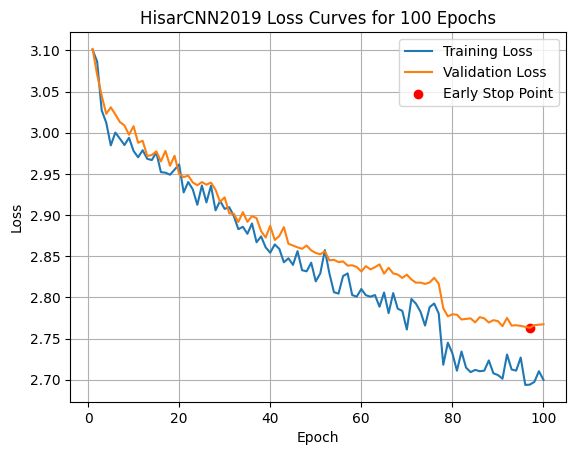

In [24]:
if(not(use_pretrained)): # Generate Loss Curves if Model was Recently Trained
    epoch_idx = np.arange(num_epochs) + 1
    plt.figure()
    plt.title(f'{model.name} Loss Curves for {num_epochs} Epochs')
    plt.plot(epoch_idx,train_loss)
    plt.plot(epoch_idx,val_loss)
    plt.scatter(np.argmin(val_loss)+1,np.min(val_loss),color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend(['Training Loss', 'Validation Loss','Early Stop Point'])
    plt.savefig(f'./results/{model.name}_{num_epochs}_Loss.png')
    plt.show()

In [26]:
# Evaluating Based on SNR Threshold 
if(device == 'cuda'): # Free any Device Memory before Start Training
    torch.cuda.empty_cache()
modelDir = './models/HisarCNN2019_100_best.pt'
model = torch.load(modelDir)
thresh = 18 # SNR Thresholdh in dB
idxThresh  = np.where(Z_test >= thresh)[0]
eval_data = test_data[idxThresh]
eval_data = torch.utils.data.TensorDataset(*eval_data)
eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
test_acc = models.train.eval(device,model,eval_loader)
print(f'Model Test Accuracy for Samples above {thresh} dB: {test_acc:.2f}')

Model Test Accuracy for Samples above 18 dB: 0.77


In [27]:
# Evaluate Test Accuracies
test_accs = [] 
model = torch.load(modelDir)
for SNR in SNRs:
    idxThresh  = np.where(Z_test >= SNR)[0]
    eval_data = test_data[idxThresh]
    eval_data = torch.utils.data.TensorDataset(*eval_data)
    eval_loader = torch.utils.data.DataLoader(eval_data,shuffle=False,batch_size=batch_size)
    test_accs.append(models.train.eval(device,model,eval_loader))

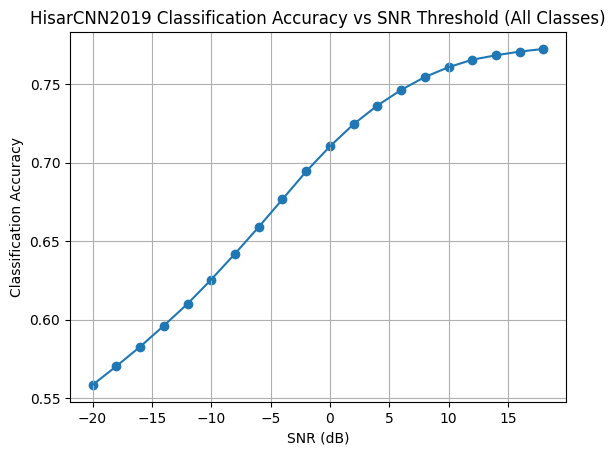

In [28]:
plt.figure()
plt.plot(SNRs,test_accs)
plt.scatter(SNRs,test_accs)
plt.grid()
plt.title(f'{model.name} Classification Accuracy vs SNR Threshold (All Classes)')
plt.xlabel('SNR (dB)')
plt.ylabel('Classification Accuracy')
plt.savefig(f'./results/{os.path.basename(modelDir).split(".pt")[0]}_SNRClassification.png')
plt.show()